## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC # svC car problème de classification (sinon SVR pour la regression)
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn import  metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,fbeta_score,roc_auc_score,confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, make_scorer
import tensorflow as tf; tf.keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from scikeras.wrappers import KerasClassifier
# from keras.callbacks import Callback
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import time
import os

import warnings
warnings.filterwarnings('ignore')

shap.initjs()

C:\Users\celine.lesur\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Données brutes:

Nous avons 4 fichiers CSV :
- X_train : dataframe d'entrainement
- X_test : dataframe de test
- y_train : array de la variable cible pour le dataframe d'entrainement
- y_test : array de la variable cible pour le dataframe de test


In [2]:
# Chargement des données brutes du fichier CSV
X_train = pd.read_csv('/tutorial-env/OCR/Projet 4/X_train.csv')
X_test = pd.read_csv('/tutorial-env/OCR/Projet 4/X_test.csv')
y_train = pd.read_csv('/tutorial-env/OCR/Projet 4/y_train.csv')
y_test = pd.read_csv('/tutorial-env/OCR/Projet 4/y_test.csv')

## Normalisation et équilibrage des données:

Afin que les différents ordres de grandeur des variables n'impactent pas les résultats des modèles, normalisons les données pour que chaque variable ait une moyenne égale à 0 et une variance égale à 1.

In [3]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

# Save the processed data
X_train_norm.to_csv('/tutorial-env/OCR/Projet 4/X_train_norm.csv', index=False)
X_test_norm.to_csv('/tutorial-env/OCR/Projet 4/X_test_norm.csv', index=False)

X_train_norm.describe(include="all")

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,...,EXT_SOURCE_2 EXT_SOURCE_3 AGE,EXT_SOURCE_2 AGE^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 AGE,EXT_SOURCE_3 AGE^2,AGE^3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,...,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05
mean,-1.740195e-17,-2.566247e-17,-1.001587e-16,6.598301e-17,3.396630e-17,-1.191998e-16,1.198930e-16,1.344139e-16,-1.502561e-16,-7.081187e-17,...,2.041155e-16,-3.093938e-16,-1.830166e-16,4.607908e-17,-5.362040e-16,-2.288249e-16,-2.544585e-17,2.618236e-17,4.396846e-16,8.224409e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-5.533760e-01,-1.374886e+00,-1.755635e+00,-1.334438e+00,-1.488335e+00,-7.174946e+00,...,-1.583469e+00,-1.498425e+00,-1.285525e+00,-1.474042e+00,-1.490044e+00,-1.236052e+00,-1.469247e+00,-1.910678e+00,-1.407703e+00,-1.229568e+00
25%,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-2.177083e-01,-8.160175e-01,-7.296359e-01,-8.105069e-01,-7.856671e-01,-2.393255e-01,...,-7.856490e-01,-7.913814e-01,-7.778655e-01,-7.364646e-01,-7.992879e-01,-8.379680e-01,-7.211528e-01,-7.006335e-01,-7.465883e-01,-6.704507e-01
50%,-3.247234e-01,-7.181585e-01,6.645063e-01,-5.788480e-01,-8.726755e-02,-2.124392e-01,-1.513679e-01,-2.378382e-01,-1.460626e-01,2.833847e-01,...,-1.347512e-01,-2.144636e-01,-1.989178e-01,-1.525855e-01,-2.310782e-01,-3.044047e-01,-2.591908e-01,-1.918845e-01,-1.652879e-01,-2.576931e-01
75%,-3.247234e-01,1.392450e+00,6.645063e-01,8.093218e-01,1.301338e-01,5.219143e-01,5.168184e-01,3.835683e-01,5.636207e-01,6.184433e-01,...,6.481073e-01,6.342508e-01,5.403890e-01,5.418466e-01,6.217268e-01,6.868723e-01,4.461135e-01,5.076919e-01,4.598731e-01,3.388940e-01
max,3.079544e+00,1.392450e+00,6.645063e-01,2.579638e+01,4.515422e+02,8.572978e+00,1.399186e+01,9.509714e+00,3.734523e+00,1.053177e+00,...,4.465937e+00,3.695439e+00,3.811027e+00,4.266265e+00,3.987615e+00,2.938628e+00,3.005412e+01,1.793057e+01,3.145881e+00,4.697029e+00


Nouséquilibrerons nos données directement dans les pipelines avec les classifieurs pour éviter toute fuite de données.

## Modélisation et évaluation:

Nous allons tester différents modèles de classification binaire et évaluer leur efficacité en terme de performances et de temps d'entainement et d'exécution.

Pour l'évaluation des performances nous allons calculer différentes métriques :
- l'accuracy (efficacité d'un modèle à prédire correctement à la fois les individus positifs et négatifs)
- la précision (nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit)
- le recall (nombre de positifs bien prédit (VP) divisé par l’ensemble des positifs)
- le F1 score (moyenne harmonique du recall et de la precision)
- le F beta score (avec beta>1, pour accorder plus d’importance au recall (autrement dit aux Faux Négatif) puisque la prédiction des difficultés de remboursement est plus importante pour l'entreprise. En effet, les FN coûtent plus d'argent que les Faux Positifs.)
- l'aire sous la courbe ROC (relation entre spécificité et sensibilité)
- l'aire sous la courbe PR (relation entre précision et recall)


Nous ajouterons un score "métier" qui correspondra au coût des erreurs de prédiction et que nous devrons minimiser.


In [4]:
# Création de la fonction de coût personnalisée pour laquelle les FN coutent 10 fois plus que les FP
def cout_score (y,y_pred) :
  tn,fp,fn,tp = confusion_matrix(y,y_pred).ravel()
  cout_total = fn*10 + fp*1
  return cout_total


### Modèle de base :
Notre modèle de base va effectuer des prédictions basées sur la valeur de la variable la plus fréquente.

In [48]:
pipeline_dummy=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier',DummyClassifier(strategy=  "most_frequent",random_state=42)]
])

#Entrainement du classifieur
clf=pipeline_dummy.fit(X_train_norm,y_train)

#Prédiction de la variable cible sur la base de données test
y_pred = clf.predict(X_test_norm)
y_pred_proba = clf.predict_proba(X_test_norm)[:, 1]

#Distribution de la variable cible sur la base de données test
print('y réel : \n' +  str(y_test.value_counts())+'\n')

#Distribution de la variable cible prédite
print('y prédit: \n' + str(pd.Series(y_pred).value_counts()))

y réel : 
TARGET_x
0           56562
1            4941
Name: count, dtype: int64

y prédit: 
0    61503
Name: count, dtype: int64


In [49]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred))) #si problème de régression, remplacé par R²
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('F beta Score (avec beta=2) : ' + str(fbeta_score(y_test,y_pred, beta=2)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_proba)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred)))

Accuracy Score : 0.919662455489976
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
F beta Score (avec beta=2) : 0.0
Aire sous la courbe ROC : 0.5
Aire sous la courbe PR : 0.0803375445100239
Score de couts des erreurs de prédiction : 49410


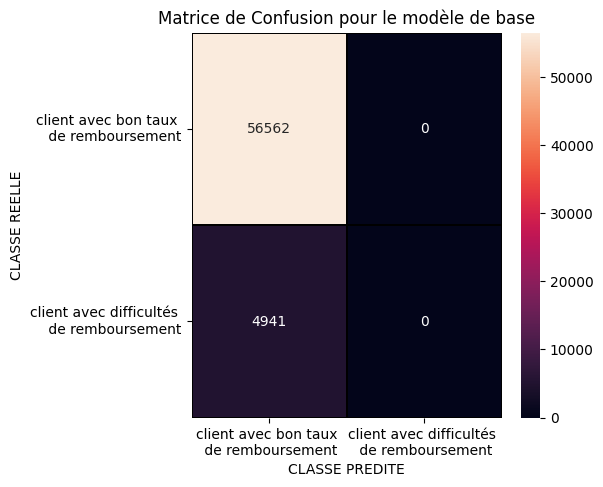

In [ ]:
# Graphique de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le modèle de base')
plt.show()

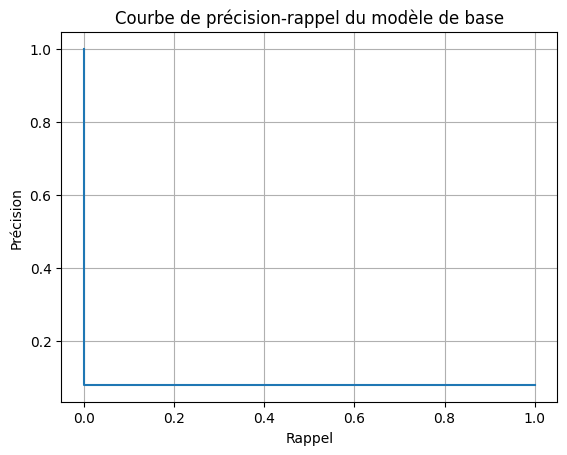

In [ ]:
# Graphique précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du modèle de base')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du modèle de base')

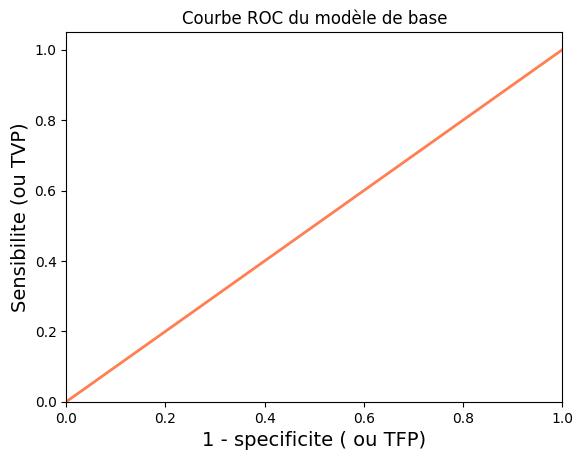

In [ ]:
# Graphique courbe ROC
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du modèle de base')

Nous voyons que prédire la classe la plus représentée (ici 0) permet d'obtenir une bonne accuracy mais des résultats médiocres pour tous les autres scores.

De plus, il n'y a aucune minimisation des FN puisque toutes les prédictions sont égales à 0 donc avec un bon taux de remboursement. Or c'est ce que l'on souhaite obtenir !

### Modèles linéaires de régression logistique :

Le modèle de régression logistique est un modèle simple qui analyse les relations entre une variable cible binaire et l’ensemble des autres variables indépendantes. Cette relation est exprimée comme une équation qui prédit la probabilité de réalisation des deux classes de la variable cible comme une combinaison linéaire de paramètres suivant une fonction logistique.


In [ ]:
pipeline_lr=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', LogisticRegression(solver="liblinear",random_state=42)]
])

params_lr = {'classifier__penalty' : ['l1','l2'],'classifier__C': [0.001,0.01,0.1,1,10,100]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_lr = GridSearchCV(pipeline_lr, params_lr,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_lr.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_lr_gs = grid_lr.best_estimator_

In [ ]:
print(best_model_lr_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 LogisticRegression(C=100, random_state=42,
                                    solver='liblinear')]])


In [ ]:
cvres_lr=pd.DataFrame(grid_lr.cv_results_)
cvres_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,split0_test_main,split1_test_main,split2_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,31.060320,7.558091,0.267143,0.044119,0.001,l1,"{'classifier__C': 0.001, 'classifier__penalty'...",0.686097,0.684768,0.683739,...,0.253139,0.254074,0.000923,12,-45676.0,-45947.0,-46031.0,-45884.666667,151.482306,9
1,28.447609,2.632347,0.234812,0.002930,0.001,l2,"{'classifier__C': 0.001, 'classifier__penalty'...",0.691828,0.688597,0.689410,...,0.252911,0.254144,0.001213,11,-45836.0,-46119.0,-46322.0,-46092.333333,199.302673,12
2,125.052881,38.773632,0.241354,0.001255,0.01,l1,"{'classifier__C': 0.01, 'classifier__penalty':...",0.695255,0.692511,0.693129,...,0.253869,0.255359,0.001371,10,-45708.0,-46023.0,-46287.0,-46006.000000,236.681220,11
3,60.806147,2.856188,0.244172,0.030281,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.696767,0.693779,0.694361,...,0.253922,0.255823,0.001458,9,-45719.0,-45865.0,-46330.0,-45971.333333,260.525537,10
4,1525.376436,23.364535,0.247346,0.003290,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.697840,0.693975,0.695495,...,0.254983,0.256914,0.001580,8,-45487.0,-45705.0,-46165.0,-45785.666667,282.608485,7
5,151.191303,2.828904,0.225126,0.002313,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.698401,0.694536,0.695751,...,0.255187,0.256938,0.001482,7,-45522.0,-45749.0,-46135.0,-45802.000000,253.046768,8
6,2810.477237,333.090005,0.239598,0.021340,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.698974,0.694999,0.696581,...,0.255617,0.257521,0.001620,6,-45394.0,-45657.0,-46085.0,-45712.000000,284.767742,4
7,293.122198,32.872215,0.237997,0.009198,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.699255,0.696011,0.697044,...,0.255908,0.257609,0.001427,3,-45443.0,-45673.0,-46047.0,-45721.000000,248.906944,6
8,3026.333324,142.067096,0.334025,0.011671,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.699060,0.695267,0.696666,...,0.255626,0.257525,0.001662,5,-45378.0,-45689.0,-46087.0,-45718.000000,290.173511,5
9,352.576267,61.853407,0.235377,0.020117,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.699865,0.696206,0.697032,...,0.255811,0.257733,0.001570,2,-45420.0,-45639.0,-46066.0,-45708.333333,268.246570,3


"mean_test_score" et "mean_train_score" renvoient des valeurs négatives car nous utilisons une fonction de coût que l'on cherche à minimiser. Cependant, dans la fonction GridSearchCV, le choix du meilleur modèle correspond toujours à la valeur du "mean_test_score" maximum, c'est pourquoi ils transforment les valeur positives en valeurs négatives dans ce cas.

In [ ]:
cols= [i for i in cvres_lr.columns if "split" not in i ]
cvres_lr=cvres_lr [cols].sort_values("rank_test_main")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
11,379.342240,68.492947,0.248609,0.014600,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697729,0.001594,1,0.257825,0.001420,1,-45691.000000,238.303728,1
9,352.576267,61.853407,0.235377,0.020117,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697701,0.001567,2,0.257733,0.001570,2,-45708.333333,268.246570,3
7,293.122198,32.872215,0.237997,0.009198,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697437,0.001353,3,0.257609,0.001427,3,-45721.000000,248.906944,6
10,3128.023713,741.611205,0.257379,0.027223,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.697022,0.001623,4,0.257585,0.001446,4,-45707.000000,250.544740,2
8,3026.333324,142.067096,0.334025,0.011671,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.696998,0.001566,5,0.257525,0.001662,5,-45718.000000,290.173511,5
6,2810.477237,333.090005,0.239598,0.021340,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.696851,0.001634,6,0.257521,0.001620,6,-45712.000000,284.767742,4
5,151.191303,2.828904,0.225126,0.002313,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696229,0.001614,7,0.256938,0.001482,7,-45802.000000,253.046768,8
4,1525.376436,23.364535,0.247346,0.003290,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.695770,0.001590,8,0.256914,0.001580,8,-45785.666667,282.608485,7
3,60.806147,2.856188,0.244172,0.030281,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.694969,0.001293,9,0.255823,0.001458,9,-45971.333333,260.525537,10
2,125.052881,38.773632,0.241354,0.001255,0.01,l1,"{'classifier__C': 0.01, 'classifier__penalty':...",0.693632,0.001175,10,0.255359,0.001371,10,-46006.000000,236.681220,11


In [ ]:
cvres_lr=cvres_lr [cols].sort_values("rank_test_f1")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
11,379.342240,68.492947,0.248609,0.014600,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697729,0.001594,1,0.257825,0.001420,1,-45691.000000,238.303728,1
9,352.576267,61.853407,0.235377,0.020117,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697701,0.001567,2,0.257733,0.001570,2,-45708.333333,268.246570,3
7,293.122198,32.872215,0.237997,0.009198,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697437,0.001353,3,0.257609,0.001427,3,-45721.000000,248.906944,6
10,3128.023713,741.611205,0.257379,0.027223,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.697022,0.001623,4,0.257585,0.001446,4,-45707.000000,250.544740,2
8,3026.333324,142.067096,0.334025,0.011671,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.696998,0.001566,5,0.257525,0.001662,5,-45718.000000,290.173511,5
6,2810.477237,333.090005,0.239598,0.021340,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.696851,0.001634,6,0.257521,0.001620,6,-45712.000000,284.767742,4
5,151.191303,2.828904,0.225126,0.002313,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696229,0.001614,7,0.256938,0.001482,7,-45802.000000,253.046768,8
4,1525.376436,23.364535,0.247346,0.003290,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.695770,0.001590,8,0.256914,0.001580,8,-45785.666667,282.608485,7
3,60.806147,2.856188,0.244172,0.030281,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.694969,0.001293,9,0.255823,0.001458,9,-45971.333333,260.525537,10
2,125.052881,38.773632,0.241354,0.001255,0.01,l1,"{'classifier__C': 0.01, 'classifier__penalty':...",0.693632,0.001175,10,0.255359,0.001371,10,-46006.000000,236.681220,11


In [ ]:
cvres_lr=cvres_lr [cols].sort_values("rank_test_custom")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
11,379.342240,68.492947,0.248609,0.014600,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697729,0.001594,1,0.257825,0.001420,1,-45691.000000,238.303728,1
10,3128.023713,741.611205,0.257379,0.027223,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.697022,0.001623,4,0.257585,0.001446,4,-45707.000000,250.544740,2
9,352.576267,61.853407,0.235377,0.020117,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697701,0.001567,2,0.257733,0.001570,2,-45708.333333,268.246570,3
6,2810.477237,333.090005,0.239598,0.021340,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.696851,0.001634,6,0.257521,0.001620,6,-45712.000000,284.767742,4
8,3026.333324,142.067096,0.334025,0.011671,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.696998,0.001566,5,0.257525,0.001662,5,-45718.000000,290.173511,5
7,293.122198,32.872215,0.237997,0.009198,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697437,0.001353,3,0.257609,0.001427,3,-45721.000000,248.906944,6
4,1525.376436,23.364535,0.247346,0.003290,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.695770,0.001590,8,0.256914,0.001580,8,-45785.666667,282.608485,7
5,151.191303,2.828904,0.225126,0.002313,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696229,0.001614,7,0.256938,0.001482,7,-45802.000000,253.046768,8
0,31.060320,7.558091,0.267143,0.044119,0.001,l1,"{'classifier__C': 0.001, 'classifier__penalty'...",0.684868,0.000965,12,0.254074,0.000923,12,-45884.666667,151.482306,9
3,60.806147,2.856188,0.244172,0.030281,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.694969,0.001293,9,0.255823,0.001458,9,-45971.333333,260.525537,10


Les hyperparamètres optimisés correspondent au couple {'C': 100, 'penalty': l2	} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -45691 avec un minimum de temps d'entrainement et de prédiction.


Evaluons ces hyper-paramètres sur le jeu de test :

(array([5678., 9281., 9505., 8925., 8011., 6763., 5564., 4314., 2687.,
         775.]),
 array([7.67105604e-08, 9.92301616e-02, 1.98460246e-01, 2.97690331e-01,
        3.96920416e-01, 4.96150501e-01, 5.95380586e-01, 6.94610671e-01,
        7.93840756e-01, 8.93070840e-01, 9.92300925e-01]),
 <BarContainer object of 10 artists>)

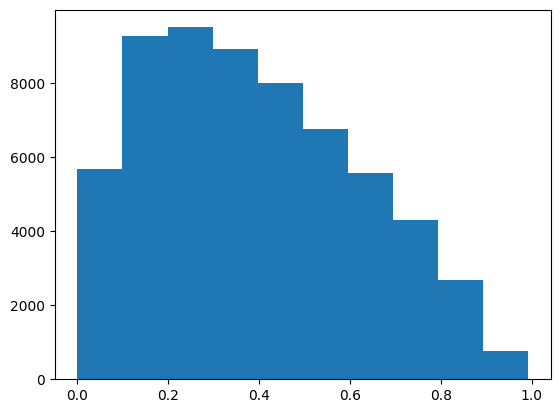

In [ ]:
y_proba_lr=best_model_lr_gs.predict_proba(X_test_norm)[:, 1]
y_pred_lr=best_model_lr_gs.predict(X_test_norm)
plt.hist(y_proba_lr)

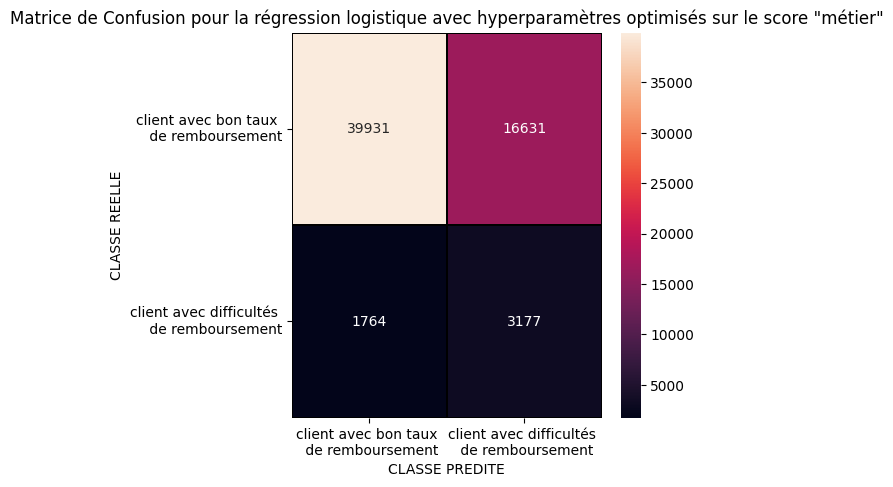

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score de la régression logistique avec hyper-paramètresn optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_lr)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_lr, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_lr)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_lr)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_lr)))

Accuracy Score : 0.7009088987529064
Precision Score : 0.16038974151857835
Recall Score : 0.6429872495446266
F1 Score : 0.25673764596549353
F beta Score (avec beta=3) : 0.4942670006378642
Aire sous la courbe ROC : 0.7370519350856997
Aire sous la courbe PR : 0.2168791662464386
Score de couts des erreurs de prédiction : 34271


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_lr_train = best_model_lr_gs.predict_proba(X_train_norm)[:, 1]
y_pred_lr_train = best_model_lr_gs.predict(X_train_norm)


In [5]:
def threshold_selection_cout(y_proba, y_train):

    scores = []
    for threshold in np.linspace(0, 1, num=100):
        y_pred = y_proba > threshold
        score = cout_score(y_train, y_pred)
        scores.append(score)

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmin()*.01, round(scores.min(),3))

    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=100), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()

Best Threshold : 0.55
Best Score : 135175


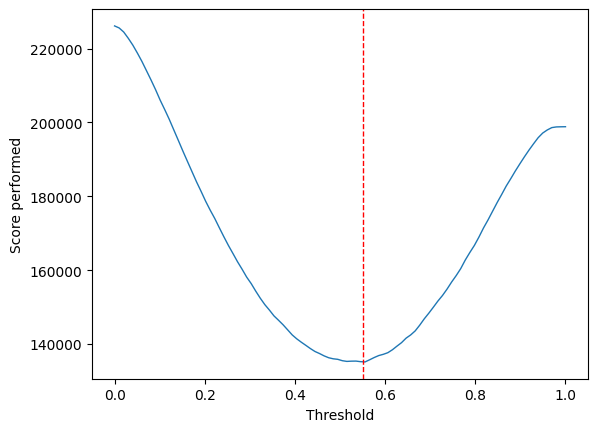

In [ ]:
threshold_selection_cout(y_proba_lr_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_lr_opt_test = (best_model_lr_gs.predict_proba(X_test_norm)[:,1] >= 0.55).astype(int)
y_lr_opt_proba_test = best_model_lr_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la régression logistique avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_lr_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_lr_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_lr_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_lr_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_lr_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_lr_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_lr_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_lr_opt_test)))

Accuracy Score : 0.7468578768515357
Precision Score : 0.17450692147494792
Recall Score : 0.5766039263307022
F1 Score : 0.26792683500258613
F beta Score (avec beta=3) : 0.4686240644789868
Aire sous la courbe ROC : 0.6691672083829885
Aire sous la courbe PR : 0.13463597700811508
Score de couts des erreurs de prédiction : 34397


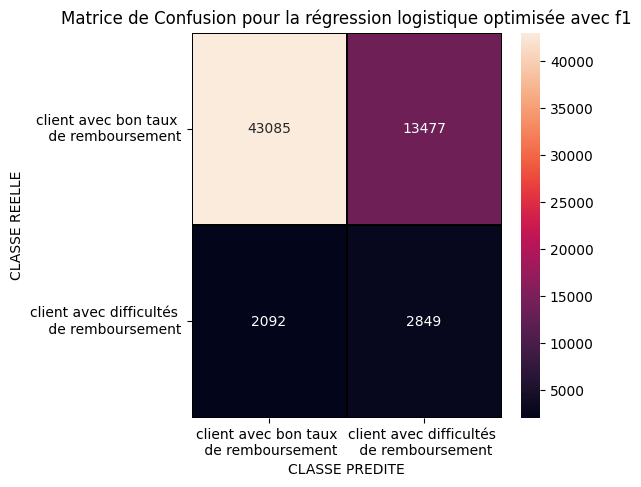

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_lr_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée avec f1')
plt.show()

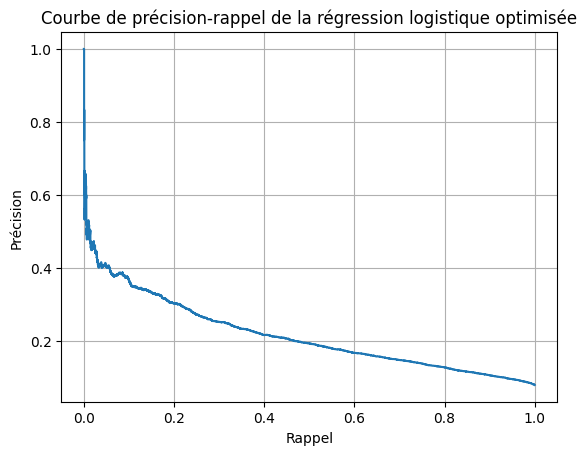

In [ ]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_lr_opt_proba_test)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

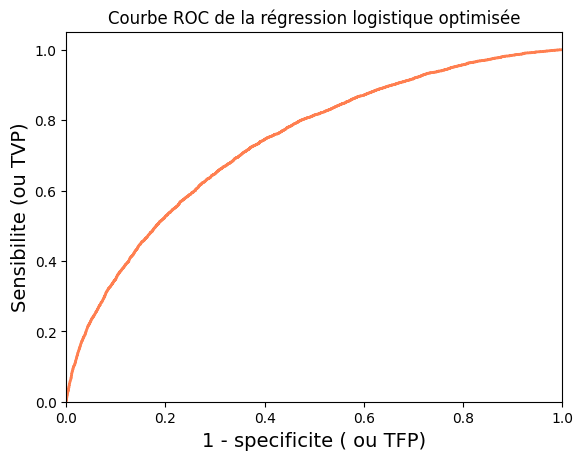

In [ ]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_lr_opt_proba_test)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

In [ ]:
lr=LogisticRegression(solver="liblinear", penalty= 'l2', C=100,random_state=42)
lr.fit(X_train_norm,y_train)


LogisticRegression(C=100, random_state=42, solver='liblinear')

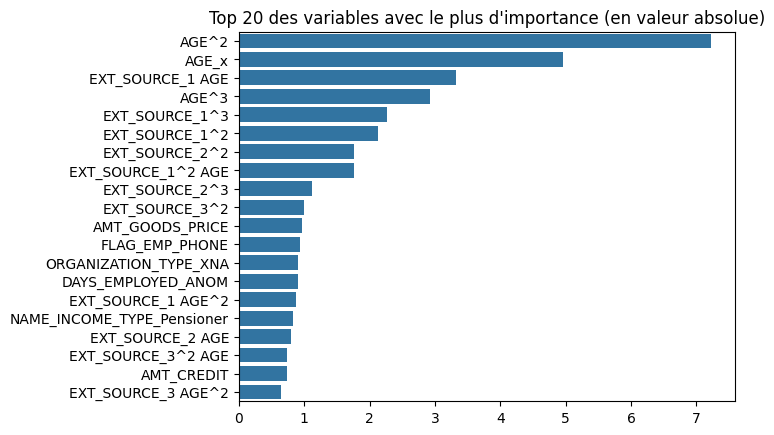

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_lr = (pd.Series(lr.coef_[0],X_train_norm.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_lr, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

La variable "AGE" ainsi que les combinaisons polynomiales utilisant les variables "AGE" et "EXT_SOURCE" sont les plus prédominantes dans ce modèle.

### Modèles linéaires de Machines à Vecteurs de Support (SVM):

Ils ont pour but de séparer linéairement les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière.

La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons, et inversement pour la version duale.

In [16]:
pipeline_svm=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', LinearSVC( tol=1e-5,max_iter=200,dual=False,random_state=42)]
])

params_svm = {'classifier__penalty' : ['l1','l2'],'classifier__C': [0.001,0.01,0.1,1,10,100]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_svm = GridSearchCV(pipeline_svm, params_svm,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_svm.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_svm_gs = grid_svm.best_estimator_

In [17]:
print(best_model_svm_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 LinearSVC(C=1, dual=False, max_iter=200, random_state=42,
                           tol=1e-05)]])


In [18]:
cvres_svm=pd.DataFrame(grid_svm.cv_results_)
cvres_svm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,split0_test_main,split1_test_main,split2_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,51.325588,1.638933,0.312965,0.013877,0.001,l1,"{'classifier__C': 0.001, 'classifier__penalty'...",0.689194,0.686121,0.687544,...,0.253916,0.253963,0.000797,12,-45890.0,-46160.0,-46034.0,-46028.000000,110.308658,10
1,110.080040,18.791963,0.250014,0.002641,0.001,l2,"{'classifier__C': 0.001, 'classifier__penalty'...",0.694804,0.691536,0.692264,...,0.253734,0.255635,0.001526,6,-45628.0,-45842.0,-46277.0,-45915.666667,270.025102,6
2,65.513254,2.804789,0.232472,0.008043,0.01,l1,"{'classifier__C': 0.01, 'classifier__penalty':...",0.694048,0.691097,0.692129,...,0.253474,0.254920,0.001151,11,-45834.0,-45968.0,-46324.0,-46042.000000,206.772016,12
3,330.776108,133.952639,0.238026,0.025337,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.697474,0.693048,0.694629,...,0.254932,0.257099,0.001918,5,-45319.0,-45691.0,-46137.0,-45715.666667,334.402286,5
4,65.551038,0.186348,0.210636,0.002477,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.694304,0.691487,0.692203,...,0.253299,0.255083,0.001432,9,-45741.0,-45954.0,-46363.0,-46019.333333,258.098603,9
5,324.018542,44.356489,0.216730,0.003253,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.699109,0.694718,0.696203,...,0.255958,0.258062,0.001850,4,-45221.0,-45563.0,-45999.0,-45594.333333,318.389000,4
6,67.061688,0.355309,0.214998,0.005341,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.694255,0.691560,0.692507,...,0.253442,0.255164,0.001379,7,-45736.0,-45939.0,-46347.0,-46007.333333,254.076541,7
7,448.489296,146.487503,0.208590,0.003770,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.699365,0.695340,0.696885,...,0.256521,0.258375,0.001495,2,-45290.0,-45458.0,-45916.0,-45554.666667,264.546572,1
8,67.379799,0.184494,0.222017,0.017391,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.694353,0.691316,0.692544,...,0.253641,0.255054,0.001160,10,-45809.0,-45968.0,-46308.0,-46028.333333,208.135106,11
9,356.718753,29.924156,0.217091,0.008741,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.699450,0.695450,0.696800,...,0.256467,0.258354,0.001557,3,-45274.0,-45485.0,-45923.0,-45560.666667,270.301478,3


In [19]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_main")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
11,389.156389,48.815380,0.212093,0.009146,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697250,0.001677,1,0.258379,0.001563,1,-45556.333333,271.772372,2
9,356.718753,29.924156,0.217091,0.008741,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697233,0.001661,2,0.258354,0.001557,3,-45560.666667,270.301478,3
7,448.489296,146.487503,0.208590,0.003770,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697197,0.001658,3,0.258375,0.001495,2,-45554.666667,264.546572,1
5,324.018542,44.356489,0.216730,0.003253,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696677,0.001823,4,0.258062,0.001850,4,-45594.333333,318.389000,4
3,330.776108,133.952639,0.238026,0.025337,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.695051,0.001832,5,0.257099,0.001918,5,-45715.666667,334.402286,5
1,110.080040,18.791963,0.250014,0.002641,0.001,l2,"{'classifier__C': 0.001, 'classifier__penalty'...",0.692868,0.001401,6,0.255635,0.001526,6,-45915.666667,270.025102,6
6,67.061688,0.355309,0.214998,0.005341,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.692774,0.001116,7,0.255164,0.001379,7,-46007.333333,254.076541,7
8,67.379799,0.184494,0.222017,0.017391,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.692738,0.001247,8,0.255054,0.001160,10,-46028.333333,208.135106,11
4,65.551038,0.186348,0.210636,0.002477,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.692664,0.001195,9,0.255083,0.001432,9,-46019.333333,258.098603,9
10,67.111636,0.510623,0.220182,0.014447,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.692591,0.001227,10,0.255096,0.001139,8,-46013.333333,200.785679,8


In [20]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_f1")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
11,389.156389,48.815380,0.212093,0.009146,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697250,0.001677,1,0.258379,0.001563,1,-45556.333333,271.772372,2
7,448.489296,146.487503,0.208590,0.003770,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697197,0.001658,3,0.258375,0.001495,2,-45554.666667,264.546572,1
9,356.718753,29.924156,0.217091,0.008741,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697233,0.001661,2,0.258354,0.001557,3,-45560.666667,270.301478,3
5,324.018542,44.356489,0.216730,0.003253,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696677,0.001823,4,0.258062,0.001850,4,-45594.333333,318.389000,4
3,330.776108,133.952639,0.238026,0.025337,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.695051,0.001832,5,0.257099,0.001918,5,-45715.666667,334.402286,5
1,110.080040,18.791963,0.250014,0.002641,0.001,l2,"{'classifier__C': 0.001, 'classifier__penalty'...",0.692868,0.001401,6,0.255635,0.001526,6,-45915.666667,270.025102,6
6,67.061688,0.355309,0.214998,0.005341,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.692774,0.001116,7,0.255164,0.001379,7,-46007.333333,254.076541,7
10,67.111636,0.510623,0.220182,0.014447,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.692591,0.001227,10,0.255096,0.001139,8,-46013.333333,200.785679,8
4,65.551038,0.186348,0.210636,0.002477,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.692664,0.001195,9,0.255083,0.001432,9,-46019.333333,258.098603,9
8,67.379799,0.184494,0.222017,0.017391,10,l1,"{'classifier__C': 10, 'classifier__penalty': '...",0.692738,0.001247,8,0.255054,0.001160,10,-46028.333333,208.135106,11


In [21]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_custom")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
7,448.489296,146.487503,0.208590,0.003770,1,l2,"{'classifier__C': 1, 'classifier__penalty': 'l2'}",0.697197,0.001658,3,0.258375,0.001495,2,-45554.666667,264.546572,1
11,389.156389,48.815380,0.212093,0.009146,100,l2,"{'classifier__C': 100, 'classifier__penalty': ...",0.697250,0.001677,1,0.258379,0.001563,1,-45556.333333,271.772372,2
9,356.718753,29.924156,0.217091,0.008741,10,l2,"{'classifier__C': 10, 'classifier__penalty': '...",0.697233,0.001661,2,0.258354,0.001557,3,-45560.666667,270.301478,3
5,324.018542,44.356489,0.216730,0.003253,0.1,l2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.696677,0.001823,4,0.258062,0.001850,4,-45594.333333,318.389000,4
3,330.776108,133.952639,0.238026,0.025337,0.01,l2,"{'classifier__C': 0.01, 'classifier__penalty':...",0.695051,0.001832,5,0.257099,0.001918,5,-45715.666667,334.402286,5
1,110.080040,18.791963,0.250014,0.002641,0.001,l2,"{'classifier__C': 0.001, 'classifier__penalty'...",0.692868,0.001401,6,0.255635,0.001526,6,-45915.666667,270.025102,6
6,67.061688,0.355309,0.214998,0.005341,1,l1,"{'classifier__C': 1, 'classifier__penalty': 'l1'}",0.692774,0.001116,7,0.255164,0.001379,7,-46007.333333,254.076541,7
10,67.111636,0.510623,0.220182,0.014447,100,l1,"{'classifier__C': 100, 'classifier__penalty': ...",0.692591,0.001227,10,0.255096,0.001139,8,-46013.333333,200.785679,8
4,65.551038,0.186348,0.210636,0.002477,0.1,l1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.692664,0.001195,9,0.255083,0.001432,9,-46019.333333,258.098603,9
0,51.325588,1.638933,0.312965,0.013877,0.001,l1,"{'classifier__C': 0.001, 'classifier__penalty'...",0.687620,0.001256,12,0.253963,0.000797,12,-46028.000000,110.308658,10


Les hyperparamètres optimisés correspondent au couple {'C': 1, 'penalty': l2	} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -45554.667 . Les temps d'entrainement et de prédiction sont par contre très longs avec cette combinaison.


Evaluons ces hyper-paramètres sur le jeu de test :

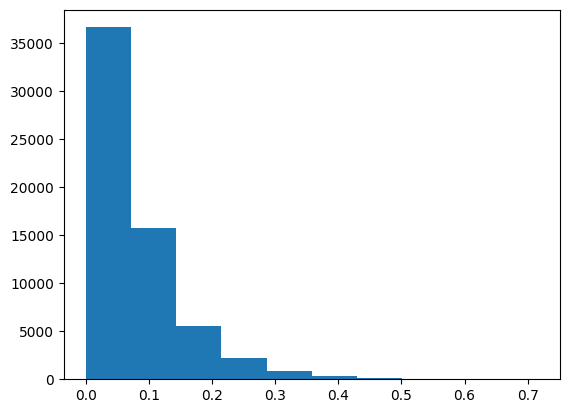

In [22]:
# Calcul des probabilité de prédiction
clf = CalibratedClassifierCV(best_model_svm_gs)
clf.fit(X_train_norm,y_train)
y_proba_svm = clf.predict_proba(X_test_norm)[:, 1]
plt.hist(y_proba_svm)

y_pred_svm=best_model_svm_gs.predict(X_test_norm)


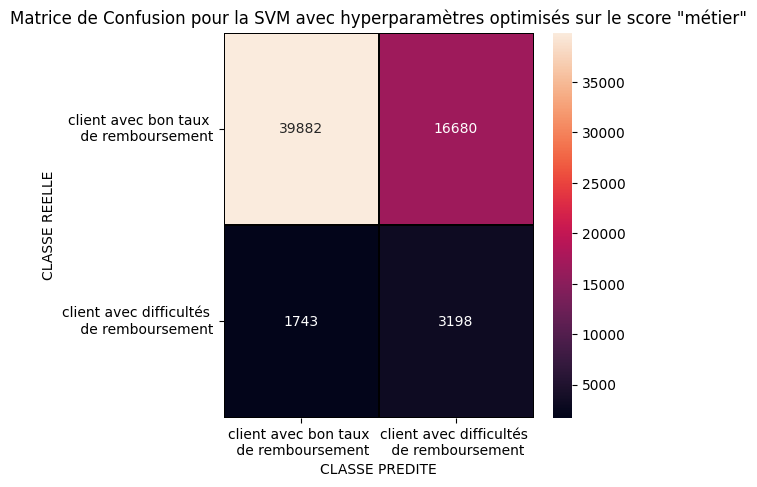

In [48]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [24]:
# score de la SVM avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_svm)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_svm)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_svm)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_svm)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_svm, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_svm)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_svm)))

Accuracy Score : 0.7004536364079801
Precision Score : 0.16088137639601569
Recall Score : 0.647237401335762
F1 Score : 0.2577057899190136
F beta Score (avec beta=3) : 0.49699286680031707
Aire sous la courbe ROC : 0.7377576208281448
Aire sous la courbe PR : 0.2144787888013057
Score de couts des erreurs de prédiction : 34110


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [26]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_svm_train = clf.predict_proba(X_train_norm)[:, 1]
y_pred_svm_train = best_model_svm_gs.predict(X_train_norm)


Best Threshold : 0.1
Best Score : 135063


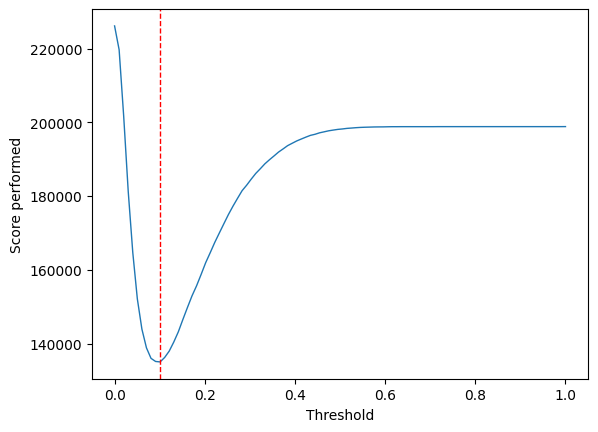

In [29]:
threshold_selection_cout(y_proba_svm_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [33]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_svm_opt_test = (clf.predict_proba(X_test_norm)[:,1] >= 0.1).astype(int)
y_svm_opt_proba_test = clf.predict_proba(X_test_norm)[:, 1]

In [34]:
# score de la régression logistique avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_svm_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_svm_opt_test)))

Accuracy Score : 0.7438498935011301
Precision Score : 0.17334300042293518
Recall Score : 0.5806516899413074
F1 Score : 0.26698306346547557
F beta Score (avec beta=3) : 0.47017371353654547
Aire sous la courbe ROC : 0.6693789194729698
Aire sous la courbe PR : 0.1343413196596176
Score de couts des erreurs de prédiction : 34402


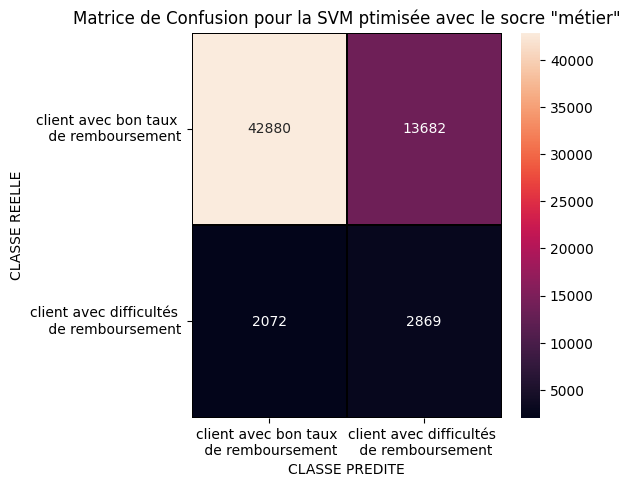

In [49]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_svm_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM ptimisée avec le score "métier"')
plt.show()

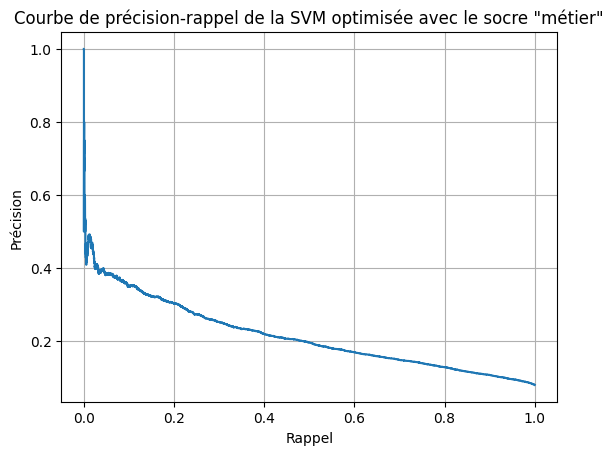

In [56]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm_opt_proba_test)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM optimisée avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM optimisée avec le socre "métier"')

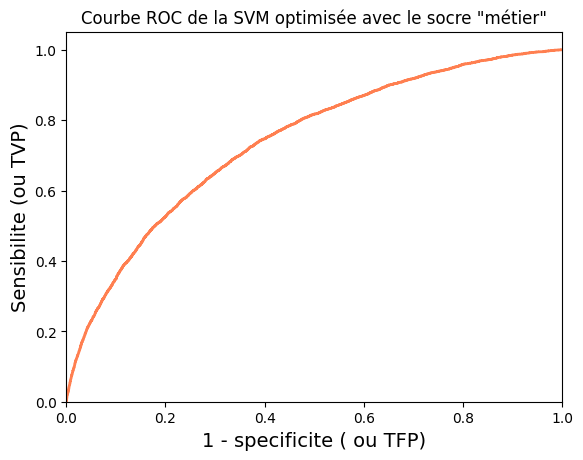

In [57]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_svm_opt_proba_test)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM optimisée avec le score "métier"')

In [38]:
svm=LinearSVC( penalty= 'l2', C=1,tol=1e-5,max_iter=200,dual=False,random_state=42)
svm.fit(X_train_norm,y_train)


LinearSVC(C=1, dual=False, max_iter=200, random_state=42, tol=1e-05)

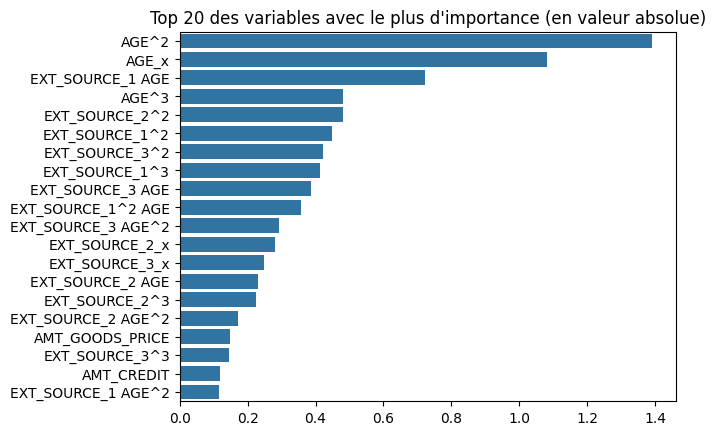

In [39]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_svm = (pd.Series(svm.coef_[0],X_train_norm.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_svm, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

La variable "AGE" ainsi que les combinaisons polynomiales utilisant les variables "AGE" et "EXT_SOURCE" sont les plus prédominantes dans ce modèle.


### Modèles non-linéaires de SVM à noyau:

 Afin de remédier au problème de l'absence de séparateur linéaire, on utilise un noyau (en anglais kernel) pour déplacer le problème dans un espace de dimension supérieure, éventuellement de dimension infinie.

 Dans ce nouvel espace, appelé espace de redescription, il est alors probable qu'il existe une séparation linéaire.

La fonction noyau choisie doit respecter certaines conditions : être symétrique et semi-définie positive. Cela peut être une fonction noyau polynômial ou exponentielle, ou gaussien(RBF),...

In [40]:
pipeline_svm_noy=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', SVC( tol=1e-5,max_iter=200,random_state=42,probability=True)]
])

params_svm_noy = {'classifier__kernel' :['poly', 'rbf', 'sigmoid'],'classifier__C': [0.001,0.01,0.1,1,10,100], 'classifier__gamma': ["scale", "auto"]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_svm_noy = GridSearchCV(pipeline_svm_noy, params_svm_noy,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_svm_noy.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_svm_noy_gs = grid_svm_noy.best_estimator_

In [41]:
print(best_model_svm_noy_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 SVC(C=100, gamma='auto', kernel='sigmoid', max_iter=200,
                     probability=True, random_state=42, tol=1e-05)]])


In [42]:
cvres_svm_noy=pd.DataFrame(grid_svm_noy.cv_results_)
cvres_svm_noy

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_main,split1_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,209.847768,0.448820,3.667515,0.222360,0.001,scale,poly,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.080875,0.080875,...,0.149546,0.149556,0.000010,26,-75371.0,-75380.0,-75383.0,-75378.000000,5.099020,35
1,239.404879,2.741421,9.329551,0.254382,0.001,scale,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.622770,0.643220,...,0.185122,0.170606,0.014048,1,-61039.0,-65383.0,-59234.0,-61885.333333,2580.666624,5
2,218.569049,0.346518,4.172505,0.122911,0.001,scale,sigmoid,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.176006,0.752277,...,0.157153,0.150002,0.007658,17,-72097.0,-65161.0,-69700.0,-68986.000000,2876.267373,18
3,204.869810,0.971480,3.717600,0.050742,0.001,auto,poly,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.080851,0.080973,...,0.149555,0.149550,0.000017,27,-75373.0,-75390.0,-75378.0,-75380.333333,7.133645,36
4,238.344059,1.481945,9.486979,0.375020,0.001,auto,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.588759,0.584881,...,0.189250,0.158268,0.038538,8,-75771.0,-59700.0,-58512.0,-64661.000000,7870.913162,8
5,218.786176,2.266230,4.221240,0.102934,0.001,auto,sigmoid,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.260661,0.217199,...,0.157364,0.157179,0.000292,10,-69313.0,-70141.0,-69476.0,-69643.333333,358.139948,21
6,204.427654,0.382466,3.664829,0.181951,0.01,scale,poly,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.081143,0.081180,...,0.149583,0.149563,0.000023,24,-75385.0,-75364.0,-75354.0,-75367.666667,12.918548,33
7,238.452949,0.732578,9.584718,0.074706,0.01,scale,rbf,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.642867,0.642794,...,0.177661,0.170355,0.013483,2,-59625.0,-65418.0,-60167.0,-61736.666667,2612.483153,4
8,217.349758,0.641357,4.208996,0.243124,0.01,scale,sigmoid,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.223675,0.753594,...,0.157197,0.150025,0.009319,16,-70357.0,-65440.0,-69662.0,-68486.333333,2172.689015,17
9,204.287254,1.346212,3.602144,0.148091,0.01,auto,poly,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.080997,0.080973,...,0.149537,0.149557,0.000022,25,-75361.0,-75381.0,-75386.0,-75376.000000,10.801234,34


In [43]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_main")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
28,236.460735,0.568773,9.490520,0.023125,10,auto,rbf,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.846428,0.006155,1,0.144514,0.025512,31,-62546.333333,1785.209107,7
31,237.725490,1.628131,9.977625,0.615112,100,scale,rbf,"{'classifier__C': 100, 'classifier__gamma': 's...",0.842180,0.022852,2,0.083825,0.014901,36,-67394.666667,2149.019053,15
34,233.174123,1.136175,9.127668,0.075670,100,auto,rbf,"{'classifier__C': 100, 'classifier__gamma': 'a...",0.823123,0.031320,3,0.103783,0.017455,34,-66653.333333,2298.078811,12
25,236.098349,1.487935,9.538246,0.087502,10,scale,rbf,"{'classifier__C': 10, 'classifier__gamma': 'sc...",0.795669,0.040729,4,0.083880,0.006817,35,-69600.666667,2543.850275,20
29,216.541900,0.491824,4.207836,0.226658,10,auto,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.767767,0.075608,5,0.159434,0.035857,6,-61316.666667,4129.297304,3
35,217.736505,0.379119,4.068421,0.251451,100,auto,sigmoid,"{'classifier__C': 100, 'classifier__gamma': 'a...",0.764723,0.094350,6,0.161092,0.033268,3,-61020.333333,3845.303658,1
26,217.584090,0.109462,4.236430,0.050998,10,scale,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'sc...",0.760617,0.100321,7,0.158767,0.034682,7,-61285.000000,3995.781359,2
32,216.501133,0.747747,4.221898,0.164294,100,scale,sigmoid,"{'classifier__C': 100, 'classifier__gamma': 's...",0.757349,0.119203,8,0.141507,0.040441,33,-62108.000000,4563.886356,6
7,238.452949,0.732578,9.584718,0.074706,0.01,scale,rbf,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.686588,0.061883,9,0.170355,0.013483,2,-61736.666667,2612.483153,4
1,239.404879,2.741421,9.329551,0.254382,0.001,scale,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.679141,0.065792,10,0.170606,0.014048,1,-61885.333333,2580.666624,5


In [44]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_f1")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
1,239.404879,2.741421,9.329551,0.254382,0.001,scale,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.679141,0.065792,10,0.170606,0.014048,1,-61885.333333,2580.666624,5
7,238.452949,0.732578,9.584718,0.074706,0.01,scale,rbf,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.686588,0.061883,9,0.170355,0.013483,2,-61736.666667,2612.483153,4
35,217.736505,0.379119,4.068421,0.251451,100,auto,sigmoid,"{'classifier__C': 100, 'classifier__gamma': 'a...",0.764723,0.094350,6,0.161092,0.033268,3,-61020.333333,3845.303658,1
22,237.291822,0.459828,9.507785,0.283433,1,auto,rbf,"{'classifier__C': 1, 'classifier__gamma': 'aut...",0.396223,0.008375,17,0.160385,0.002026,4,-66593.333333,542.834741,11
11,218.040549,2.577888,4.205152,0.160216,0.01,auto,sigmoid,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.275028,0.044859,21,0.160264,0.003916,5,-68128.666667,1940.040263,16
29,216.541900,0.491824,4.207836,0.226658,10,auto,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.767767,0.075608,5,0.159434,0.035857,6,-61316.666667,4129.297304,3
26,217.584090,0.109462,4.236430,0.050998,10,scale,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'sc...",0.760617,0.100321,7,0.158767,0.034682,7,-61285.000000,3995.781359,2
4,238.344059,1.481945,9.486979,0.375020,0.001,auto,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.632634,0.064811,11,0.158268,0.038538,8,-64661.000000,7870.913162,8
17,216.758795,1.063418,4.296054,0.162345,0.1,auto,sigmoid,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",0.260756,0.010381,22,0.158214,0.000172,9,-69002.000000,196.399253,19
5,218.786176,2.266230,4.221240,0.102934,0.001,auto,sigmoid,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.242435,0.018423,23,0.157179,0.000292,10,-69643.333333,358.139948,21


In [45]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_custom")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
35,217.736505,0.379119,4.068421,0.251451,100,auto,sigmoid,"{'classifier__C': 100, 'classifier__gamma': 'a...",0.764723,0.094350,6,0.161092,0.033268,3,-61020.333333,3845.303658,1
26,217.584090,0.109462,4.236430,0.050998,10,scale,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'sc...",0.760617,0.100321,7,0.158767,0.034682,7,-61285.000000,3995.781359,2
29,216.541900,0.491824,4.207836,0.226658,10,auto,sigmoid,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.767767,0.075608,5,0.159434,0.035857,6,-61316.666667,4129.297304,3
7,238.452949,0.732578,9.584718,0.074706,0.01,scale,rbf,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.686588,0.061883,9,0.170355,0.013483,2,-61736.666667,2612.483153,4
1,239.404879,2.741421,9.329551,0.254382,0.001,scale,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.679141,0.065792,10,0.170606,0.014048,1,-61885.333333,2580.666624,5
32,216.501133,0.747747,4.221898,0.164294,100,scale,sigmoid,"{'classifier__C': 100, 'classifier__gamma': 's...",0.757349,0.119203,8,0.141507,0.040441,33,-62108.000000,4563.886356,6
28,236.460735,0.568773,9.490520,0.023125,10,auto,rbf,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.846428,0.006155,1,0.144514,0.025512,31,-62546.333333,1785.209107,7
4,238.344059,1.481945,9.486979,0.375020,0.001,auto,rbf,"{'classifier__C': 0.001, 'classifier__gamma': ...",0.632634,0.064811,11,0.158268,0.038538,8,-64661.000000,7870.913162,8
10,238.059499,1.057763,9.514724,0.064141,0.01,auto,rbf,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.625273,0.066762,12,0.156651,0.037378,12,-64964.666667,7659.050870,9
13,236.495988,1.243949,9.242934,0.131338,0.1,scale,rbf,"{'classifier__C': 0.1, 'classifier__gamma': 's...",0.555417,0.069795,13,0.152098,0.018060,14,-66028.000000,2712.181533,10


Les hyperparamètres optimisés correspondent au couple {'C': 100, 'gamma': auto, 'kernel': sigmoid} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -61020.667 avec un minimum de temps d'entrainement et de prédiction.


Evaluons ces hyper-paramètres sur le jeu de test :

(array([5.0000e+00, 3.1000e+01, 1.0950e+03, 1.0506e+04, 4.3241e+04,
        5.8050e+03, 6.8500e+02, 9.4000e+01, 2.9000e+01, 1.2000e+01]),
 array([0.38172466, 0.40905805, 0.43639143, 0.46372481, 0.49105819,
        0.51839158, 0.54572496, 0.57305834, 0.60039172, 0.62772511,
        0.65505849]),
 <BarContainer object of 10 artists>)

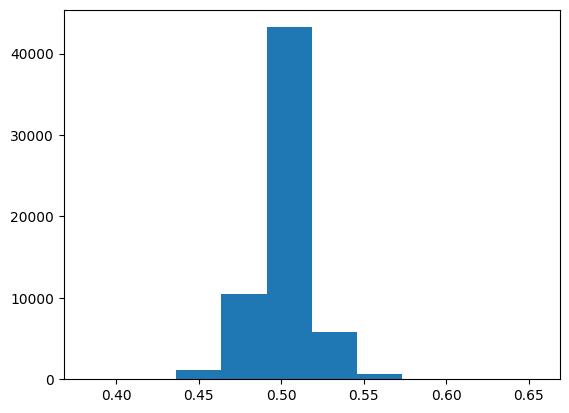

In [46]:
y_proba_svm_noy=best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1]
y_pred_svm_noy=best_model_svm_noy_gs.predict(X_test_norm)
plt.hist(y_proba_svm_noy)

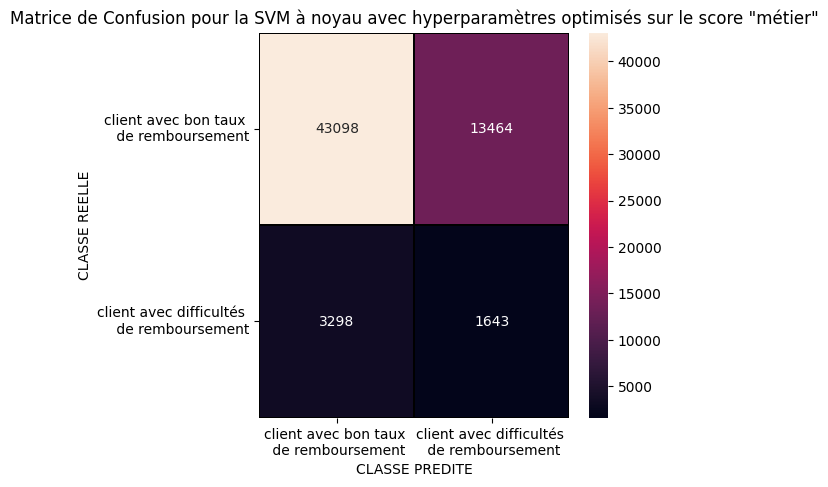

In [47]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_test, y_pred_svm_noy)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [52]:
# score de la SVM à noyau avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_svm_noy)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm_noy)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_svm_noy)))

Accuracy Score : 0.7274604490837845
Precision Score : 0.10875752962202952
Recall Score : 0.3325237806112123
F1 Score : 0.16390662410215484
F beta Score (avec beta=3) : 0.2757821941721498
Aire sous la courbe ROC : 0.5939402906275952
Aire sous la courbe PR : 0.09647247757243978
Score de couts des erreurs de prédiction : 46444


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [53]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_svm_noy_train = best_model_svm_noy_gs.predict_proba(X_train_norm)[:, 1]
y_pred_svm_noy_train = best_model_svm_noy_gs.predict(X_train_norm)

Best Threshold : 0.5
Best Score : 176735


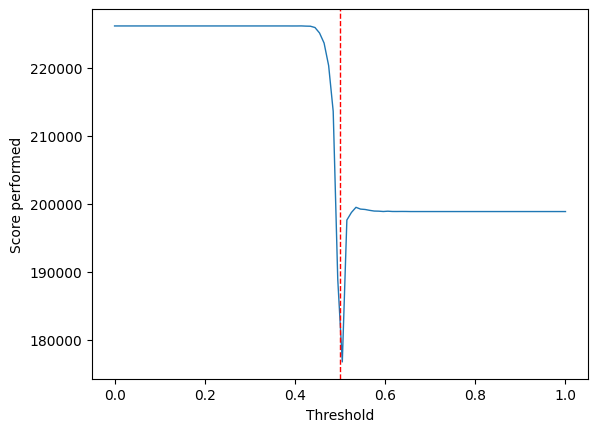

In [54]:
threshold_selection_cout(y_proba_svm_noy_train,y_train)

Le meilleur seuil est celui par défaut, l'évaluation du modèle a donc déja été fait. Pour rappel :

In [ ]:
# score de la SVM à noyau avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_svm_noy)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm_noy)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_svm_noy)))

Accuracy Score : 0.7274604490837845
Precision Score : 0.10875752962202952
Recall Score : 0.3325237806112123
F1 Score : 0.16390662410215484
F beta Score (avec beta=3) : 0.2757821941721498
Aire sous la courbe ROC : 0.5939402906275952
Aire sous la courbe PR : 0.09647247757243978
Score de couts des erreurs de prédiction : 46444


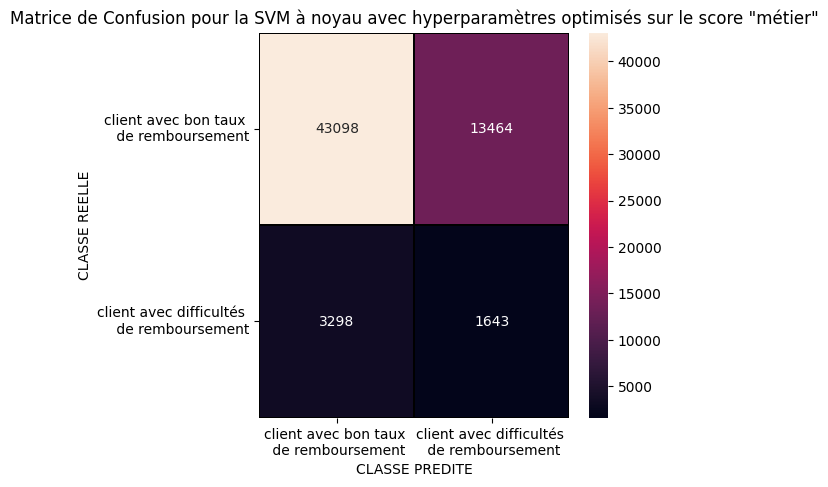

In [ ]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_test, y_pred_svm_noy)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau optimisée sur le score "métier"')
plt.show()

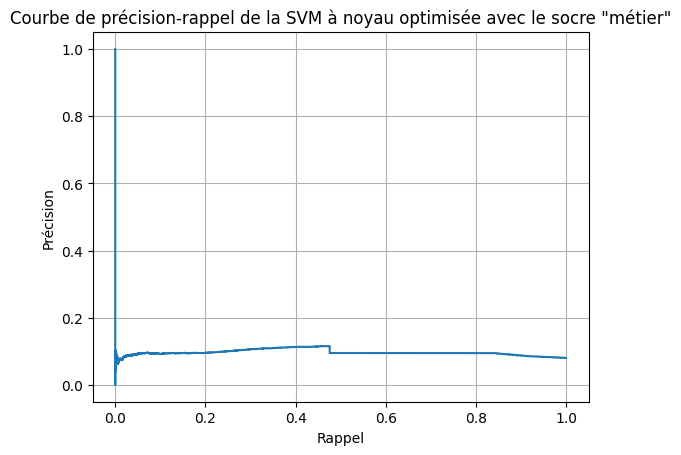

In [55]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_proba_svm_noy)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM à noyau optimisée avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM à noyau optimisée avec le socre "métier"')

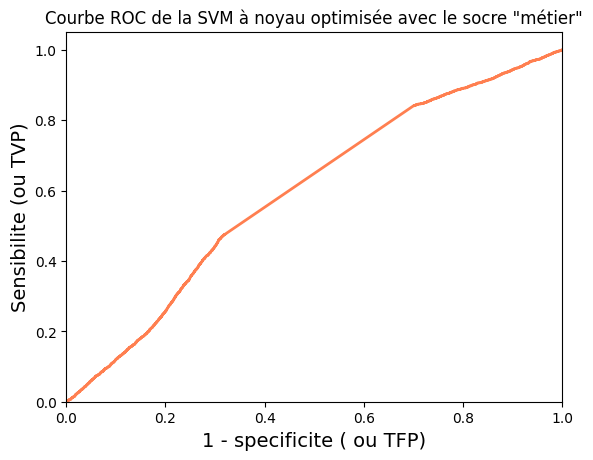

In [58]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_proba_svm_noy)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM à noyau optimisée avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

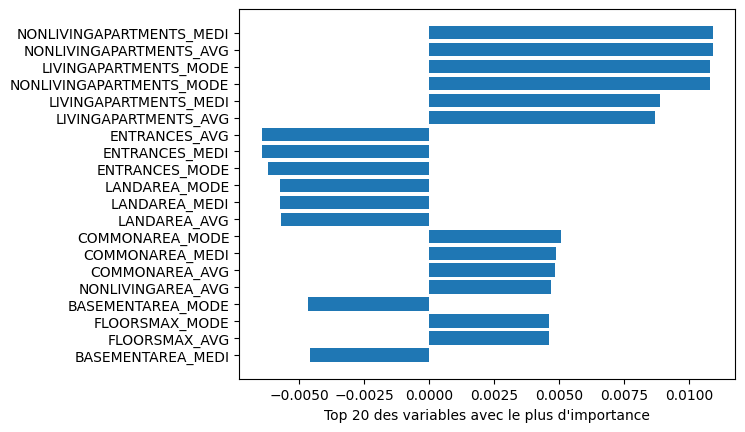

In [61]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_svm_noy_gs, X_train_norm,y_train)

feature_names = X_train_norm.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Ici ce sont les variables liés à l'habitat du client qui sont les plus prédominantes dans ce modèle. Aucune variable issue du feature engineering ne sont dans le top 20 ici.

### Modèles de réseaux de neurones:


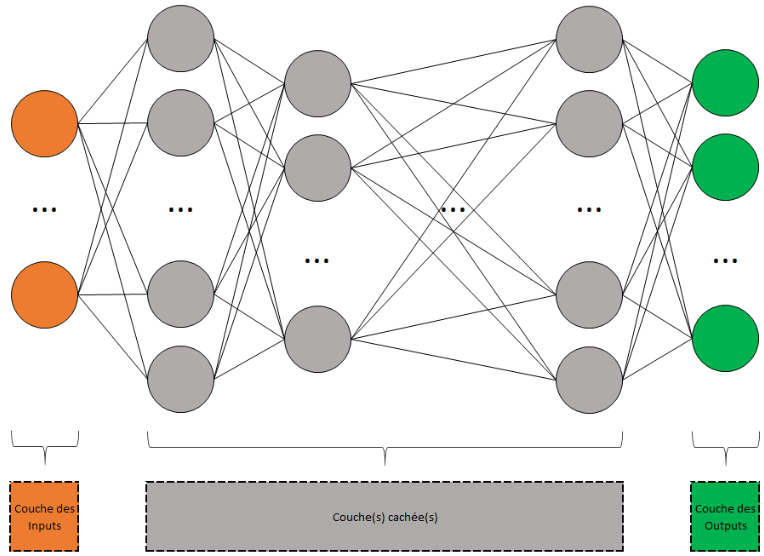

Dans un réseau, le neurone est une unité qui reçoit l'information, procède à des calculs simples, et la transmet à une autre unité. On distingue trois types de neurones dans un réseau artificiel :
- Les neurones d'entrées qui reçoivent les données du monde extérieur (couche d'entrée) ;
- Les neurones de traitement (couche cachée) ;
- Les neurones de sorties (couche de sortie).

Il permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classe (la fonction d'activation est la fonction softmax).

Chaque connexion a un poids spécifique qui influence la transmission de l'information d'une unité à une autre. Les informations provenant d'une connexion avec un poids important seront ainsi dominantes à l'entrée du neurone suivant, comparativement à celles provenant de connexions à poids faible. Ces dernières ne sont cependant pas ignorées lors du traitement de l'information. Les poids sont mis à jour de façon itérative grâce à l'algorithme du gradient.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale ! Plus il y a de paramètres, plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

In [5]:
def create_model():
    #Nous utilisons la fonction Sequential() qui est approprié pour notre problème(cf bibliothèque Keras: https://keras.io/guides/sequential_model/)
      model = tf.keras.Sequential()
      #On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train, c'est à dire 276.
      model.add(tf.keras.layers.InputLayer(input_shape=[276]))
      #Première couche de notre réseau de neurones avec 276 perceptrons.
  #La fonction sigmoide est particulièrement indiqué pour les problèmes de classification.
      model.add(tf.keras.layers.Dense(276, input_dim=2, activation='sigmoid'))
      #Seconde couche car nous sommes dans un problème non linéaire
      model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      model.compile(metrics=[tf.keras.metrics.Accuracy(name='my_accuracy'), tf.keras.metrics.Precision(name='my_precision'),tf.keras.metrics.Recall(name='my_recall'),tf.keras.metrics.F1Score( name="my_f1_score"),tf.keras.metrics.FBetaScore( beta=3.0, name="my_fbeta_score"),tf.keras.metrics.AUC(curve='ROC',name='my_aucroc'),tf.keras.metrics.AUC(curve='PR',name='my_aucpr'),tf.keras.metrics.FalsePositives(name="my_FP"),tf.keras.metrics.FalseNegatives(name="my_FN")],
                  loss="binary_crossentropy",
                  optimizer="adam")
      return model


In [6]:
model = KerasClassifier(build_fn=create_model, verbose=0)


In [7]:
custom_metric = make_scorer(cout_score, greater_is_better=False)

In [8]:
pipeline_neuron=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', model]
])

batch_size = [50,100, 100,150,200]
epochs = [10, 50, 100]
params_neuron = dict(classifier__batch_size=batch_size, classifier__epochs=epochs)
scorer = {'main': 'accuracy', 'f1' : 'f1','custom':custom_metric}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_neuron = GridSearchCV(pipeline_neuron, params_neuron, scoring=scorer, refit='custom', cv=3, n_jobs=None)
grid_neuron.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_neuron_gs = grid_neuron.best_estimator_


In [9]:
print(best_model_neuron_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 KerasClassifier(batch_size=150, build_fn=<function create_model at 0x0000021E9C25EC00>, epochs=10, verbose=0)]])


In [10]:
cvres_neuron=pd.DataFrame(grid_neuron.cv_results_)
cvres_neuron

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__batch_size,param_classifier__epochs,params,split0_test_main,split1_test_main,split2_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,181.888714,9.526346,3.798276,0.290874,50,10,"{'classifier__batch_size': 50, 'classifier__ep...",0.861590,0.863273,0.864894,...,0.178177,0.181630,0.002617,5,-59446.0,-59623.0,-59922.0,-59663.666667,196.442245,5
1,830.897680,7.558692,3.749630,0.043424,50,50,"{'classifier__batch_size': 50, 'classifier__ep...",0.871175,0.861115,0.857747,...,0.167321,0.166769,0.005109,9,-61144.0,-60340.0,-60769.0,-60751.000000,328.478310,9
2,1626.246288,58.204091,3.378215,0.219033,50,100,"{'classifier__batch_size': 50, 'classifier__ep...",0.861444,0.861859,0.857821,...,0.165844,0.165326,0.002355,10,-61114.0,-60693.0,-60880.0,-60895.666667,172.229175,10
3,91.933835,1.369345,2.028430,0.087047,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.852127,0.850018,0.863808,...,0.186599,0.200896,0.010282,3,-57243.0,-57614.0,-59291.0,-58049.333333,890.959159,3
4,433.036318,5.304705,1.973114,0.111309,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.853005,0.862737,0.860357,...,0.174703,0.170752,0.002874,6,-60627.0,-60684.0,-60195.0,-60502.000000,218.325445,7
5,865.228411,9.109300,2.068774,0.185265,100,100,"{'classifier__batch_size': 100, 'classifier__e...",0.862432,0.863176,0.859589,...,0.168664,0.168109,0.002105,8,-60880.0,-60504.0,-60654.0,-60679.333333,154.543054,8
6,91.774491,1.478275,1.904796,0.007098,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.871175,0.840908,0.857052,...,0.201390,0.195843,0.016330,4,-60226.0,-56858.0,-58072.0,-58385.333333,1392.716610,4
7,441.378439,6.795850,2.043183,0.158161,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.856761,0.857286,0.865979,...,0.162730,0.164964,0.001642,12,-60913.0,-60825.0,-61030.0,-60922.666667,83.969571,11
8,862.522754,11.465633,1.956855,0.008140,100,100,"{'classifier__batch_size': 100, 'classifier__e...",0.856725,0.857188,0.857540,...,0.160293,0.165291,0.003537,11,-60727.0,-60752.0,-61299.0,-60926.000000,263.948227,12
9,67.321740,0.955206,1.449506,0.044589,150,10,"{'classifier__batch_size': 150, 'classifier__e...",0.846396,0.850079,0.851223,...,0.197580,0.207630,0.010594,1,-56048.0,-57852.0,-58334.0,-57411.333333,983.900176,1


In [11]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_main")
cvres_neuron.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__batch_size,param_classifier__epochs,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
13,250.855149,1.408946,1.228180,0.057695,200,50,"{'classifier__batch_size': 200, 'classifier__e...",0.868073,0.002565,1,0.160178,0.009715,15,-61164.333333,650.088370,14
1,830.897680,7.558692,3.749630,0.043424,50,50,"{'classifier__batch_size': 50, 'classifier__ep...",0.863346,0.005704,2,0.166769,0.005109,9,-60751.000000,328.478310,9
10,310.375864,4.877130,1.434333,0.014807,150,50,"{'classifier__batch_size': 150, 'classifier__e...",0.863322,0.001565,3,0.170379,0.006919,7,-60492.000000,495.306639,6
11,612.457359,6.769710,1.471343,0.016502,150,100,"{'classifier__batch_size': 150, 'classifier__e...",0.863313,0.002163,4,0.160756,0.002073,14,-61197.666667,138.396371,15
0,181.888714,9.526346,3.798276,0.290874,50,10,"{'classifier__batch_size': 50, 'classifier__ep...",0.863252,0.001349,5,0.181630,0.002617,5,-59663.666667,196.442245,5
5,865.228411,9.109300,2.068774,0.185265,100,100,"{'classifier__batch_size': 100, 'classifier__e...",0.861732,0.001546,6,0.168109,0.002105,8,-60679.333333,154.543054,8
14,496.503160,3.894153,1.194783,0.002918,200,100,"{'classifier__batch_size': 200, 'classifier__e...",0.861399,0.004050,7,0.161290,0.008339,13,-61159.666667,549.679503,13
2,1626.246288,58.204091,3.378215,0.219033,50,100,"{'classifier__batch_size': 50, 'classifier__ep...",0.860374,0.001814,8,0.165326,0.002355,10,-60895.666667,172.229175,10
7,441.378439,6.795850,2.043183,0.158161,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.860009,0.004227,9,0.164964,0.001642,12,-60922.666667,83.969571,11
4,433.036318,5.304705,1.973114,0.111309,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.858700,0.004142,10,0.170752,0.002874,6,-60502.000000,218.325445,7


In [12]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_f1")
cvres_neuron.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__batch_size,param_classifier__epochs,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
9,67.321740,0.955206,1.449506,0.044589,150,10,"{'classifier__batch_size': 150, 'classifier__e...",0.849233,0.002060,15,0.207630,0.010594,1,-57411.333333,983.900176,1
12,55.891749,0.600577,1.253788,0.009572,200,10,"{'classifier__batch_size': 200, 'classifier__e...",0.852952,0.002255,14,0.205393,0.001441,2,-57685.333333,108.102832,2
3,91.933835,1.369345,2.028430,0.087047,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.855318,0.006065,13,0.200896,0.010282,3,-58049.333333,890.959159,3
6,91.774491,1.478275,1.904796,0.007098,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.856379,0.012366,12,0.195843,0.016330,4,-58385.333333,1392.716610,4
0,181.888714,9.526346,3.798276,0.290874,50,10,"{'classifier__batch_size': 50, 'classifier__ep...",0.863252,0.001349,5,0.181630,0.002617,5,-59663.666667,196.442245,5
4,433.036318,5.304705,1.973114,0.111309,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.858700,0.004142,10,0.170752,0.002874,6,-60502.000000,218.325445,7
10,310.375864,4.877130,1.434333,0.014807,150,50,"{'classifier__batch_size': 150, 'classifier__e...",0.863322,0.001565,3,0.170379,0.006919,7,-60492.000000,495.306639,6
5,865.228411,9.109300,2.068774,0.185265,100,100,"{'classifier__batch_size': 100, 'classifier__e...",0.861732,0.001546,6,0.168109,0.002105,8,-60679.333333,154.543054,8
1,830.897680,7.558692,3.749630,0.043424,50,50,"{'classifier__batch_size': 50, 'classifier__ep...",0.863346,0.005704,2,0.166769,0.005109,9,-60751.000000,328.478310,9
2,1626.246288,58.204091,3.378215,0.219033,50,100,"{'classifier__batch_size': 50, 'classifier__ep...",0.860374,0.001814,8,0.165326,0.002355,10,-60895.666667,172.229175,10


In [13]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_custom")
cvres_neuron.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__batch_size,param_classifier__epochs,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
9,67.321740,0.955206,1.449506,0.044589,150,10,"{'classifier__batch_size': 150, 'classifier__e...",0.849233,0.002060,15,0.207630,0.010594,1,-57411.333333,983.900176,1
12,55.891749,0.600577,1.253788,0.009572,200,10,"{'classifier__batch_size': 200, 'classifier__e...",0.852952,0.002255,14,0.205393,0.001441,2,-57685.333333,108.102832,2
3,91.933835,1.369345,2.028430,0.087047,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.855318,0.006065,13,0.200896,0.010282,3,-58049.333333,890.959159,3
6,91.774491,1.478275,1.904796,0.007098,100,10,"{'classifier__batch_size': 100, 'classifier__e...",0.856379,0.012366,12,0.195843,0.016330,4,-58385.333333,1392.716610,4
0,181.888714,9.526346,3.798276,0.290874,50,10,"{'classifier__batch_size': 50, 'classifier__ep...",0.863252,0.001349,5,0.181630,0.002617,5,-59663.666667,196.442245,5
10,310.375864,4.877130,1.434333,0.014807,150,50,"{'classifier__batch_size': 150, 'classifier__e...",0.863322,0.001565,3,0.170379,0.006919,7,-60492.000000,495.306639,6
4,433.036318,5.304705,1.973114,0.111309,100,50,"{'classifier__batch_size': 100, 'classifier__e...",0.858700,0.004142,10,0.170752,0.002874,6,-60502.000000,218.325445,7
5,865.228411,9.109300,2.068774,0.185265,100,100,"{'classifier__batch_size': 100, 'classifier__e...",0.861732,0.001546,6,0.168109,0.002105,8,-60679.333333,154.543054,8
1,830.897680,7.558692,3.749630,0.043424,50,50,"{'classifier__batch_size': 50, 'classifier__ep...",0.863346,0.005704,2,0.166769,0.005109,9,-60751.000000,328.478310,9
2,1626.246288,58.204091,3.378215,0.219033,50,100,"{'classifier__batch_size': 50, 'classifier__ep...",0.860374,0.001814,8,0.165326,0.002355,10,-60895.666667,172.229175,10


Les hyperparamètres optimisés correspondent au couple {'batch_size': 150, 'epochs': 10} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -57411.333 avec un temps d'entrainement et de prédiction peu élevé.


Evaluons ces hyper-paramètres sur le jeu de test :

(array([41670.,  5649.,  3265.,  2295.,  1843.,  1582.,  1364.,  1286.,
         1228.,  1321.]),
 array([0.        , 0.09999959, 0.19999918, 0.29999876, 0.39999837,
        0.49999794, 0.59999752, 0.69999713, 0.79999673, 0.89999628,
        0.99999589]),
 <BarContainer object of 10 artists>)

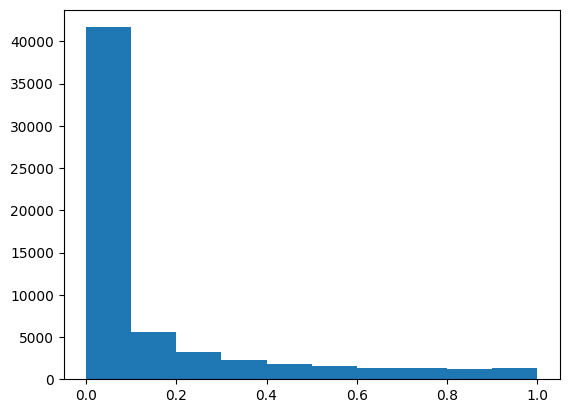

In [14]:
y_proba_neuron=best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]
y_pred_neuron=best_model_neuron_gs.predict(X_test_norm)
plt.hist(y_proba_neuron)

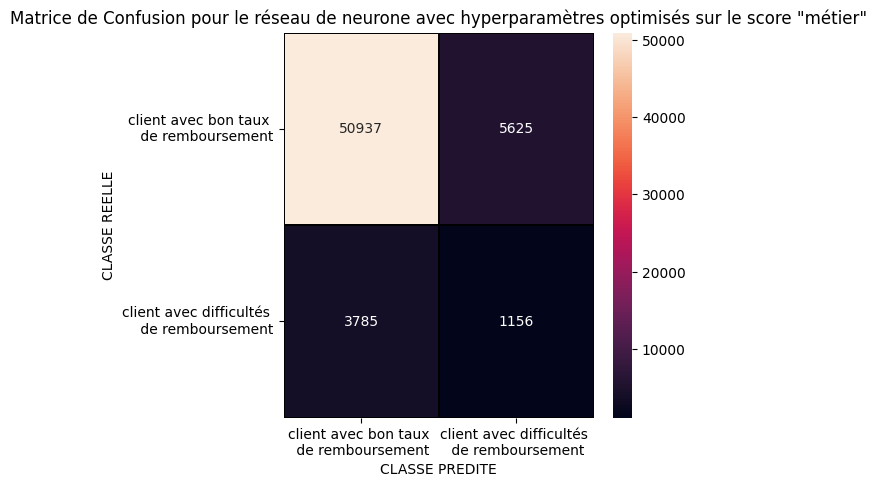

In [24]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_pred_neuron)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurone avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [16]:
# score du réseau de neurones avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_neuron)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_neuron)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_neuron)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_neuron)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_neuron, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_neuron)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_neuron)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_neuron)))

Accuracy Score : 0.8469993333658521
Precision Score : 0.17047633092464237
Recall Score : 0.23396073669297712
F1 Score : 0.19723596655860773
F beta Score (avec beta=3) : 0.2255609756097561
Aire sous la courbe ROC : 0.6511875901702106
Aire sous la courbe PR : 0.14297253606350152
Score de couts des erreurs de prédiction : 43475


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [17]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_neuron_train = best_model_neuron_gs.predict_proba(X_train_norm)[:, 1]
y_pred_neuron_train = best_model_neuron_gs.predict(X_train_norm)

Best Threshold : 0.23
Best Score : 53917


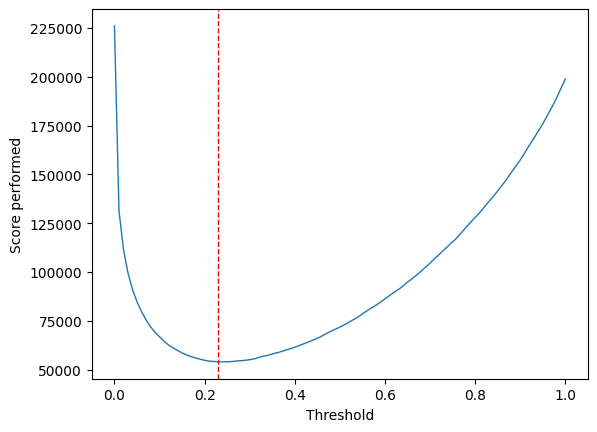

In [20]:
threshold_selection_cout(y_proba_neuron_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [22]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_neuron_opt_test = (best_model_neuron_gs.predict_proba(X_test_norm)[:,1] >= 0.23).astype(int)
y_neuron_opt_proba_test = best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]

In [23]:
# score du réseau de neurones avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_neuron_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_neuron_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_neuron_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_neuron_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_neuron_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_neuron_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_neuron_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_neuron_opt_test)))

Accuracy Score : 0.7686454319301498
Precision Score : 0.14544205222171325
Recall Score : 0.38554948391013966
F1 Score : 0.21120904706469315
F beta Score (avec beta=3) : 0.33091875553702643
Aire sous la courbe ROC : 0.5938302208985301
Aire sous la courbe PR : 0.10543855385848944
Score de couts des erreurs de prédiction : 41553


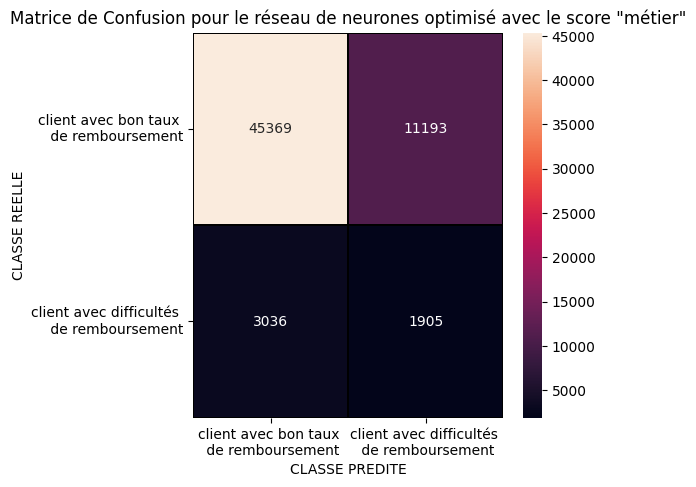

In [28]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_neuron_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurones optimisé avec le score "métier"')
plt.show()

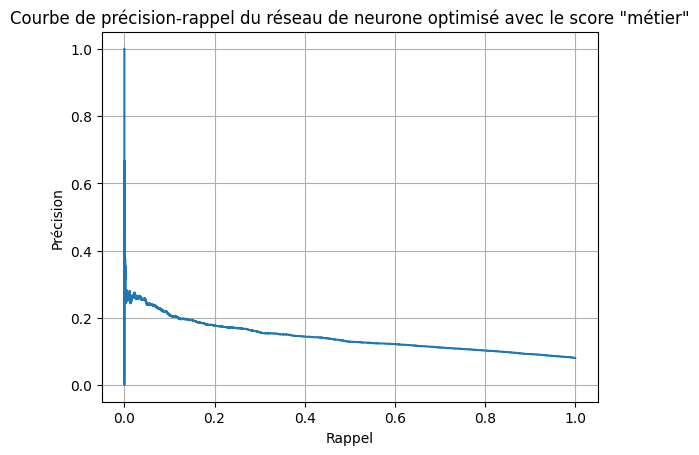

In [26]:
# Graphique précision-rappel
precision_neuron, recall_neuron, _ = precision_recall_curve(y_test, y_neuron_opt_proba_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_neuron, recall=recall_neuron)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du réseau de neurone optimisé avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du réseau de neurone optimisé avec le score "métier"')

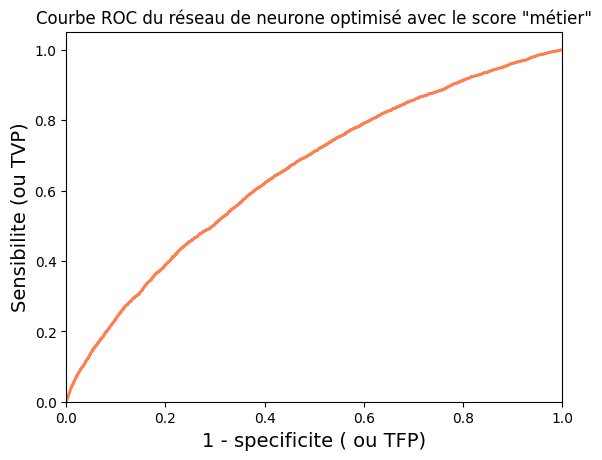

In [27]:
# Graphique courbe ROC
[fpr_neuron, tpr_neuron, thr_neuron] = metrics.roc_curve(y_test, y_neuron_opt_proba_test)
plt.plot(fpr_neuron, tpr_neuron, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du réseau de neurone optimisé avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

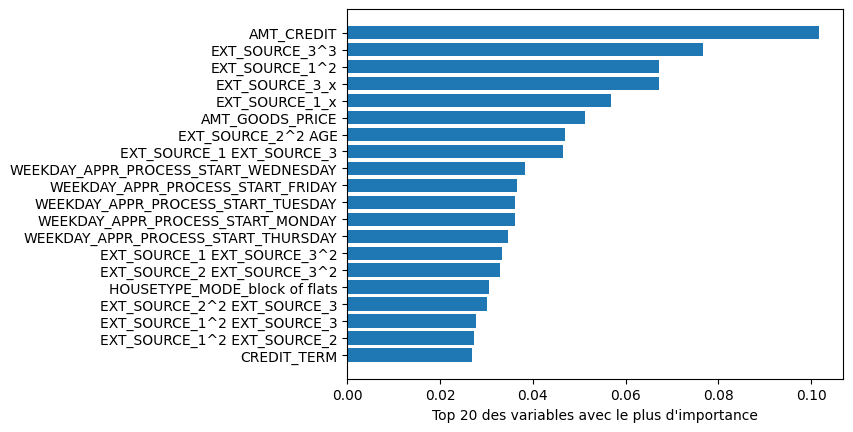

In [29]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance_neuron = permutation_importance(best_model_neuron_gs, X_train_norm,y_train)

feature_names = X_train_norm.columns
features = np.array(feature_names)

sorted_idx_neuron = abs(perm_importance_neuron.importances_mean).argsort()
plt.barh(features[sorted_idx_neuron[-20:]], perm_importance_neuron.importances_mean[sorted_idx_neuron[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Ici c'est la vriable "AMT_CREDIT" correspondant au montant du prêt qui est prédominantes. Les combinaisons des variables polynomiales liées à l'âge et aux EXT_SOURCE ainsi que les variables "EXT_SOURCE_1" et "EXT_SOURCE_3" sont également importante dans ce modèle.

### Modèles ensembliste de forêts aléatoires (Random Forest):


La base du calcul repose sur l'apprentissage par arbres de décision partiellement indépendants les uns des autres.

Pour chaque arbre à créer :

- On crée un échantillon en tirant avec remise autant d'observations que le jeu de données inital (technique connue sous le nom de  bagging, aussi appelé bootstrap aggregating ),
- Sur toutes les variables, on n'en retient qu'un plus petit nombre au hasard.
- On entraîne un arbre de décision à partir de l'échantillon créé en ne tenant compte que des variables sélectionnées. On limite la croissance de l'arbre de décision par validation croisée.

In [6]:
pipeline_rfc=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', RandomForestClassifier(random_state=42)]
])

params_rfc = {"classifier__max_depth": [None] + list(range(2, 20, 3)),"classifier__max_features": ["sqrt", "log2"]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_rfc = GridSearchCV(pipeline_rfc, params_rfc,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_rfc.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_rfc_gs = grid_rfc.best_estimator_

In [7]:
print(best_model_rfc_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        random_state=42)]])


In [8]:
cvres_rfc=pd.DataFrame(grid_rfc.cv_results_)
cvres_rfc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,split0_test_main,split1_test_main,split2_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,604.093750,45.014322,6.031606,0.383359,None,sqrt,"{'classifier__max_depth': None, 'classifier__m...",0.916442,0.915771,0.915258,...,0.078015,0.073359,0.003395,14,-64110.0,-64219.0,-63955.0,-64094.666667,108.321538,14
1,327.224814,1.129298,6.099468,0.206370,None,log2,"{'classifier__max_depth': None, 'classifier__m...",0.913113,0.912723,0.911539,...,0.109502,0.100318,0.006630,13,-63447.0,-63335.0,-62892.0,-63224.666667,239.633516,13
2,79.451193,0.315805,1.112909,0.027097,2,sqrt,"{'classifier__max_depth': 2, 'classifier__max_...",0.658013,0.664781,0.660886,...,0.237050,0.238188,0.000935,10,-47988.0,-48468.0,-48580.0,-48345.333333,256.776600,3
3,49.003512,1.724769,1.124143,0.038173,2,log2,"{'classifier__max_depth': 2, 'classifier__max_...",0.662915,0.666598,0.668142,...,0.239924,0.239925,0.000486,8,-47901.0,-48283.0,-48210.0,-48131.333333,165.574421,2
4,187.638908,8.255050,1.579033,0.179488,5,sqrt,"{'classifier__max_depth': 5, 'classifier__max_...",0.736156,0.737814,0.737543,...,0.246534,0.248473,0.001400,6,-48870.0,-49058.0,-49485.0,-49137.666667,257.314766,4
5,99.410246,1.346646,1.594821,0.216000,5,log2,"{'classifier__max_depth': 5, 'classifier__max_...",0.722254,0.722278,0.724860,...,0.251327,0.251938,0.001635,5,-47499.0,-48208.0,-48131.0,-47946.000000,317.636060,1
6,279.092728,7.273307,2.176991,0.053298,8,sqrt,"{'classifier__max_depth': 8, 'classifier__max_...",0.791520,0.793569,0.794249,...,0.251198,0.252160,0.001066,4,-50603.0,-50966.0,-51054.0,-50874.333333,195.196198,7
7,149.758914,4.205319,2.179628,0.006955,8,log2,"{'classifier__max_depth': 8, 'classifier__max_...",0.773484,0.773874,0.773115,...,0.252421,0.255701,0.002388,2,-49157.0,-49386.0,-49988.0,-49510.333333,350.460966,5
8,352.513364,0.688775,2.986070,0.029726,11,sqrt,"{'classifier__max_depth': 11, 'classifier__max...",0.838189,0.835738,0.833821,...,0.243323,0.247117,0.004822,7,-52599.0,-53547.0,-53560.0,-53235.333333,449.986913,9
9,200.017724,6.248185,3.100930,0.127914,11,log2,"{'classifier__max_depth': 11, 'classifier__max...",0.812239,0.810373,0.808297,...,0.255823,0.258218,0.002570,1,-50479.0,-50992.0,-51054.0,-50841.666667,257.690167,6


In [9]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_main")
cvres_rfc.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
0,604.093750,45.014322,6.031606,0.383359,None,sqrt,"{'classifier__max_depth': None, 'classifier__m...",0.915824,0.000485,1,0.073359,0.003395,14,-64094.666667,108.321538,14
1,327.224814,1.129298,6.099468,0.206370,None,log2,"{'classifier__max_depth': None, 'classifier__m...",0.912458,0.000669,2,0.100318,0.006630,13,-63224.666667,239.633516,13
12,458.654704,2.217559,4.410337,0.072905,17,sqrt,"{'classifier__max_depth': 17, 'classifier__max...",0.886374,0.002077,3,0.210077,0.004442,12,-57818.666667,287.907778,12
13,263.573781,7.371661,4.745655,0.241067,17,log2,"{'classifier__max_depth': 17, 'classifier__max...",0.867330,0.002838,4,0.239004,0.002796,9,-55159.333333,150.386908,10
10,419.511488,7.210629,3.918374,0.168718,14,sqrt,"{'classifier__max_depth': 14, 'classifier__max...",0.867134,0.002482,5,0.235209,0.004888,11,-55469.333333,380.105541,11
11,229.753121,3.237286,3.891510,0.204600,14,log2,"{'classifier__max_depth': 14, 'classifier__max...",0.842969,0.002985,6,0.254916,0.002692,3,-52708.000000,154.106024,8
8,352.513364,0.688775,2.986070,0.029726,11,sqrt,"{'classifier__max_depth': 11, 'classifier__max...",0.835916,0.001788,7,0.247117,0.004822,7,-53235.333333,449.986913,9
9,200.017724,6.248185,3.100930,0.127914,11,log2,"{'classifier__max_depth': 11, 'classifier__max...",0.810303,0.001610,8,0.258218,0.002570,1,-50841.666667,257.690167,6
6,279.092728,7.273307,2.176991,0.053298,8,sqrt,"{'classifier__max_depth': 8, 'classifier__max_...",0.793112,0.001160,9,0.252160,0.001066,4,-50874.333333,195.196198,7
7,149.758914,4.205319,2.179628,0.006955,8,log2,"{'classifier__max_depth': 8, 'classifier__max_...",0.773491,0.000310,10,0.255701,0.002388,2,-49510.333333,350.460966,5


In [10]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_f1")
cvres_rfc.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
9,200.017724,6.248185,3.100930,0.127914,11,log2,"{'classifier__max_depth': 11, 'classifier__max...",0.810303,0.001610,8,0.258218,0.002570,1,-50841.666667,257.690167,6
7,149.758914,4.205319,2.179628,0.006955,8,log2,"{'classifier__max_depth': 8, 'classifier__max_...",0.773491,0.000310,10,0.255701,0.002388,2,-49510.333333,350.460966,5
11,229.753121,3.237286,3.891510,0.204600,14,log2,"{'classifier__max_depth': 14, 'classifier__max...",0.842969,0.002985,6,0.254916,0.002692,3,-52708.000000,154.106024,8
6,279.092728,7.273307,2.176991,0.053298,8,sqrt,"{'classifier__max_depth': 8, 'classifier__max_...",0.793112,0.001160,9,0.252160,0.001066,4,-50874.333333,195.196198,7
5,99.410246,1.346646,1.594821,0.216000,5,log2,"{'classifier__max_depth': 5, 'classifier__max_...",0.723131,0.001223,12,0.251938,0.001635,5,-47946.000000,317.636060,1
4,187.638908,8.255050,1.579033,0.179488,5,sqrt,"{'classifier__max_depth': 5, 'classifier__max_...",0.737171,0.000726,11,0.248473,0.001400,6,-49137.666667,257.314766,4
8,352.513364,0.688775,2.986070,0.029726,11,sqrt,"{'classifier__max_depth': 11, 'classifier__max...",0.835916,0.001788,7,0.247117,0.004822,7,-53235.333333,449.986913,9
3,49.003512,1.724769,1.124143,0.038173,2,log2,"{'classifier__max_depth': 2, 'classifier__max_...",0.665885,0.002193,13,0.239925,0.000486,8,-48131.333333,165.574421,2
13,263.573781,7.371661,4.745655,0.241067,17,log2,"{'classifier__max_depth': 17, 'classifier__max...",0.867330,0.002838,4,0.239004,0.002796,9,-55159.333333,150.386908,10
2,79.451193,0.315805,1.112909,0.027097,2,sqrt,"{'classifier__max_depth': 2, 'classifier__max_...",0.661226,0.002773,14,0.238188,0.000935,10,-48345.333333,256.776600,3


In [11]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_custom")
cvres_rfc.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
5,99.410246,1.346646,1.594821,0.216000,5,log2,"{'classifier__max_depth': 5, 'classifier__max_...",0.723131,0.001223,12,0.251938,0.001635,5,-47946.000000,317.636060,1
3,49.003512,1.724769,1.124143,0.038173,2,log2,"{'classifier__max_depth': 2, 'classifier__max_...",0.665885,0.002193,13,0.239925,0.000486,8,-48131.333333,165.574421,2
2,79.451193,0.315805,1.112909,0.027097,2,sqrt,"{'classifier__max_depth': 2, 'classifier__max_...",0.661226,0.002773,14,0.238188,0.000935,10,-48345.333333,256.776600,3
4,187.638908,8.255050,1.579033,0.179488,5,sqrt,"{'classifier__max_depth': 5, 'classifier__max_...",0.737171,0.000726,11,0.248473,0.001400,6,-49137.666667,257.314766,4
7,149.758914,4.205319,2.179628,0.006955,8,log2,"{'classifier__max_depth': 8, 'classifier__max_...",0.773491,0.000310,10,0.255701,0.002388,2,-49510.333333,350.460966,5
9,200.017724,6.248185,3.100930,0.127914,11,log2,"{'classifier__max_depth': 11, 'classifier__max...",0.810303,0.001610,8,0.258218,0.002570,1,-50841.666667,257.690167,6
6,279.092728,7.273307,2.176991,0.053298,8,sqrt,"{'classifier__max_depth': 8, 'classifier__max_...",0.793112,0.001160,9,0.252160,0.001066,4,-50874.333333,195.196198,7
11,229.753121,3.237286,3.891510,0.204600,14,log2,"{'classifier__max_depth': 14, 'classifier__max...",0.842969,0.002985,6,0.254916,0.002692,3,-52708.000000,154.106024,8
8,352.513364,0.688775,2.986070,0.029726,11,sqrt,"{'classifier__max_depth': 11, 'classifier__max...",0.835916,0.001788,7,0.247117,0.004822,7,-53235.333333,449.986913,9
13,263.573781,7.371661,4.745655,0.241067,17,log2,"{'classifier__max_depth': 17, 'classifier__max...",0.867330,0.002838,4,0.239004,0.002796,9,-55159.333333,150.386908,10


Les hyperparamètres optimisés correspondent à la combinaison {'max depth': 5 , 'max features': 'log2'} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -47946.00 avec un temps d'entrainement et de prédiction correct.


Evaluons ces hyper-paramètres sur le jeu de test :

(array([ 683., 5017., 8824., 8937., 8764., 8767., 8553., 6863., 4222.,
         873.]),
 array([0.08344123, 0.15025311, 0.21706499, 0.28387687, 0.35068875,
        0.41750063, 0.48431252, 0.5511244 , 0.61793628, 0.68474816,
        0.75156004]),
 <BarContainer object of 10 artists>)

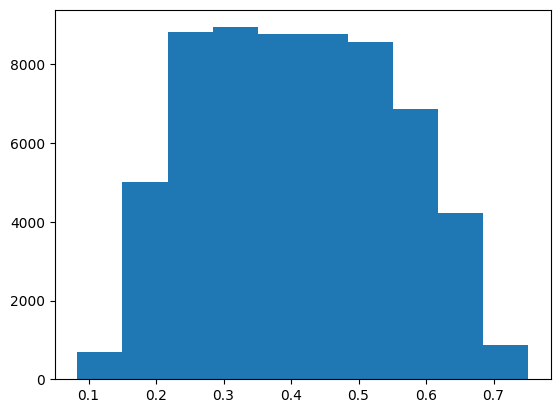

In [12]:
y_proba_rfc=best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]
y_pred_rfc=best_model_rfc_gs.predict(X_test_norm)
plt.hist(y_proba_rfc)

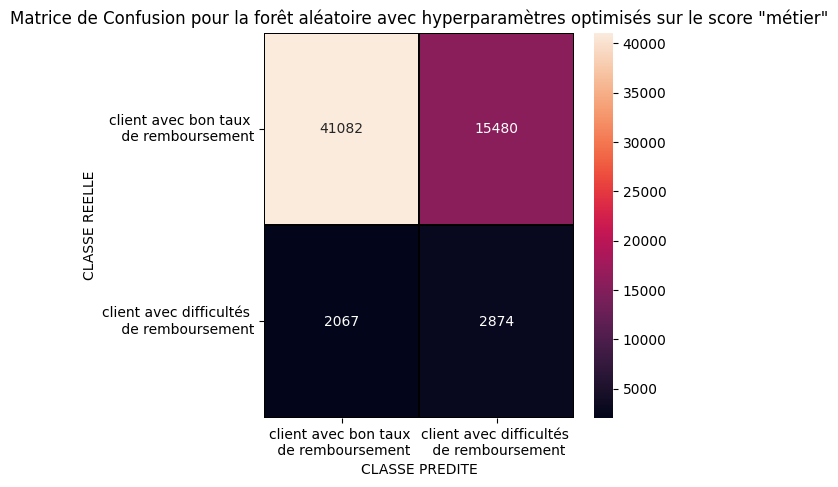

In [13]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [15]:
# score de la forêt aléatoire avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_rfc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_rfc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_rfc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_rfc)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_rfc, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_rfc)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_rfc)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_rfc)))

Accuracy Score : 0.7146968440563874
Precision Score : 0.15658711997384767
Recall Score : 0.5816636308439587
F1 Score : 0.24674822923374115
F beta Score (avec beta=3) : 0.45747576524521266
Aire sous la courbe ROC : 0.7144405823876082
Aire sous la courbe PR : 0.18193140236465674
Score de couts des erreurs de prédiction : 36150


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [16]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_rfc_train = best_model_rfc_gs.predict_proba(X_train_norm)[:, 1]
y_pred_rfc_train = best_model_rfc_gs.predict(X_train_norm)

Best Threshold : 0.47000000000000003
Best Score : 142260


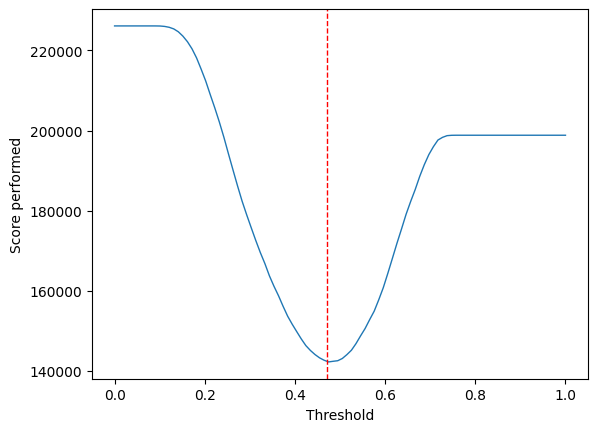

In [18]:
threshold_selection_cout(y_proba_rfc_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [19]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_rfc_opt_test = (best_model_rfc_gs.predict_proba(X_test_norm)[:,1] >= 0.47).astype(int)
y_rfc_opt_proba_test = best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]

In [20]:
# score de la forêt aléatoire avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_rfc_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_rfc_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_rfc_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_rfc_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_rfc_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_rfc_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_rfc_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_rfc_opt_test)))

Accuracy Score : 0.6603580313155456
Precision Score : 0.14363603861279942
Recall Score : 0.6504756122242461
F1 Score : 0.2353113445839587
F beta Score (avec beta=3) : 0.48081382302341236
Aire sous la courbe ROC : 0.6558484634439006
Aire sous la courbe PR : 0.12151167121439964
Score de couts des erreurs de prédiction : 36432


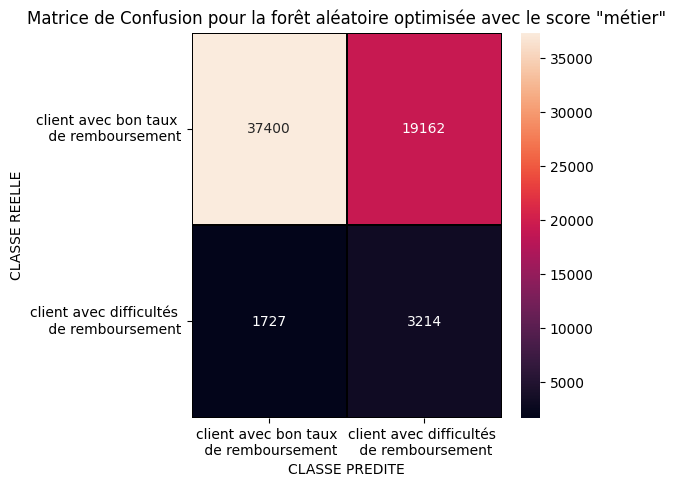

In [21]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_rfc_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire optimisée avec le score "métier"')
plt.show()

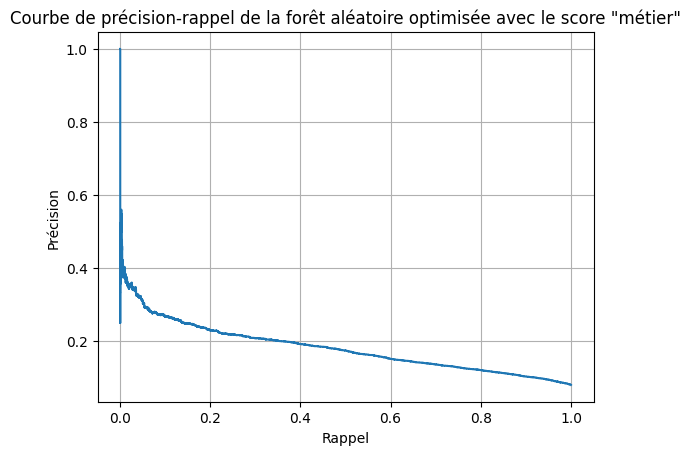

In [22]:
# Graphique précision-rappel
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_rfc_opt_proba_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_rfc, recall=recall_rfc)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la forêt aléatoire optimisée avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la forêt aléatoire optimisée avec le score "métier"')

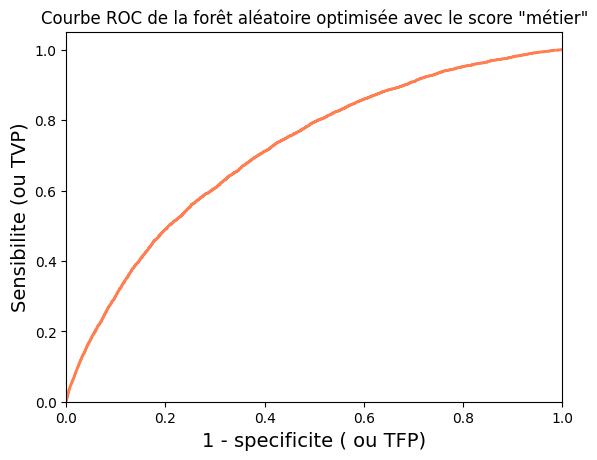

In [23]:
# Graphique courbe ROC
[fpr_rfc, tpr_rfc, thr_rfc] = metrics.roc_curve(y_test, y_rfc_opt_proba_test)
plt.plot(fpr_rfc, tpr_rfc, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la forêt aléatoire optimisée avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

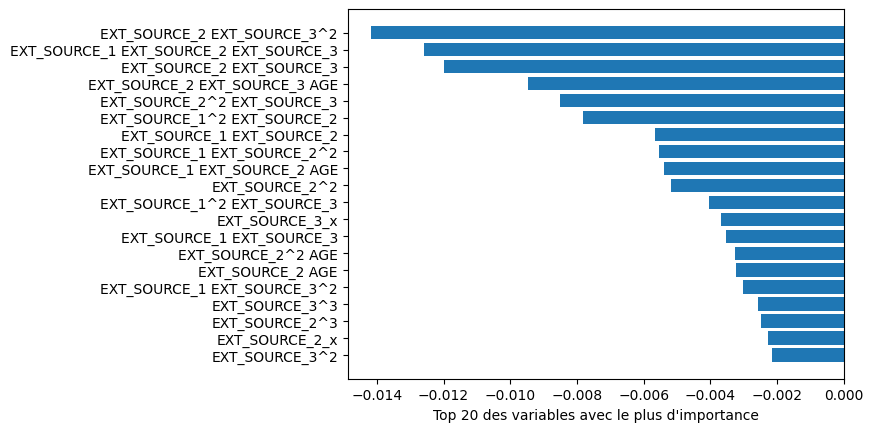

In [28]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_rfc_gs, X_train_norm,y_train)

feature_names = X_train_norm.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")


Nous pouvons voir que les combinaisons créées avec les données EXT_SOURCE et AGE ont une importance élevée dans ce modèle optimisé de forêt aléatoire.


In [ ]:
#  Sélection du seuil pour diminuer le nombre de variables si nombre de lignes peu important et risque d'overfitting

# from sklearn.feature_selection import SelectFromModel
# select = SelectFromModel(rfc.fit(X_train_eq,y_train_eq), prefit=True, threshold=0.01)
# X_train2 = select.transform(X_train_eq)
# print(X_train2.shape)

# avec boucle
# selectbislist=[]
# Xtrainbis=[]
# for i in [x / 1000.0 for x in range(5, 26, 5)]   :
#   selectbis=SelectFromModel(best_model_rfc_gs, prefit=True, threshold=i)
#   selectbislist.append(selectbis)
#   temp=selectbis.transform(X_train_eq)
#   Xtrainbis.append(temp)

### Modèles ensembliste séquentiel du XGBoost:

Le boosting va produire des modèles qui sont très dépendants les uns des autres, contrairement au principe du bagging. En effet les modèles sont entraînés itérativement comme suit :

- La première étape consiste à créer un premier modèle de base partir d'un algorithme choisi. Il est entraîné sur les données. Au début, on attribue des poids égaux à toutes les observations. À partir des résultats obtenus de ce modèle, si une observation est mal classée, cela augmente son poids.

- Ensuite, un second modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Il est entraîné à l'aide des données pondérées obtenues dans la première étape. Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.

- Les prédictions du dernier modèle ajouté seront les prédictions globales pondérées fournies par les anciens modèles d’arbres.


In [30]:
pipeline_bst=imbpipeline(steps=[
    ['scaler', StandardScaler()],
    ['smote', SMOTE(random_state=42)],
    ['rus', RandomUnderSampler(random_state=42)],
    ['classifier', XGBClassifier(objective='binary:logistic',random_state=42)]
])

params_bst = {"classifier__learning_rate" : [0.1,0.5,1],"classifier__max_depth": [None] + list(range(2, 10, 2))}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_bst = GridSearchCV(pipeline_bst, params_bst,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_bst.fit(X_train_norm,y_train)

#récupération des meilleurs hyperparamètres
best_model_bst_gs = grid_bst.best_estimator_

In [31]:
print(best_model_bst_gs)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42)),
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_t...one, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,

In [32]:
cvres_bst=pd.DataFrame(grid_bst.cv_results_)
cvres_bst

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,params,split0_test_main,split1_test_main,split2_test_main,...,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_custom,split1_test_custom,split2_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,43.295078,2.036863,0.644222,0.048855,0.1,None,"{'classifier__learning_rate': 0.1, 'classifier...",0.918991,0.919052,0.918953,...,0.037648,0.032322,0.004151,13,-65449.0,-65309.0,-65128.0,-65295.333333,131.403535,13
1,24.347824,0.211925,0.564223,0.074862,0.1,2,"{'classifier__learning_rate': 0.1, 'classifier...",0.914637,0.913467,0.912917,...,0.087412,0.080100,0.007018,8,-64258.0,-63886.0,-63715.0,-63953.000000,226.684803,8
2,32.349090,1.092645,0.667941,0.080980,0.1,4,"{'classifier__learning_rate': 0.1, 'classifier...",0.918564,0.918759,0.918453,...,0.035482,0.030102,0.004146,15,-65547.0,-65405.0,-65232.0,-65394.666667,128.805624,15
3,39.679398,1.419887,0.590156,0.041509,0.1,6,"{'classifier__learning_rate': 0.1, 'classifier...",0.918991,0.919052,0.918953,...,0.037648,0.032322,0.004151,13,-65449.0,-65309.0,-65128.0,-65295.333333,131.403535,13
4,48.373709,1.554128,0.601379,0.047019,0.1,8,"{'classifier__learning_rate': 0.1, 'classifier...",0.919088,0.919198,0.919039,...,0.045709,0.042711,0.002122,11,-65000.0,-65000.0,-64860.0,-64953.333333,65.996633,11
5,42.116101,2.353136,0.674030,0.048749,0.5,None,"{'classifier__learning_rate': 0.5, 'classifier...",0.916015,0.915637,0.915551,...,0.103095,0.098360,0.004471,6,-63110.0,-63402.0,-62995.0,-63169.000000,171.314526,6
6,25.854140,0.732611,0.530364,0.024245,0.5,2,"{'classifier__learning_rate': 0.5, 'classifier...",0.918942,0.919198,0.918600,...,0.048739,0.035749,0.009185,12,-65399.0,-65378.0,-64788.0,-65188.333333,283.208208,12
7,28.298696,1.053429,0.577145,0.030732,0.5,4,"{'classifier__learning_rate': 0.5, 'classifier...",0.918588,0.918491,0.917465,...,0.071095,0.069778,0.000932,9,-64096.0,-64104.0,-64089.0,-64096.333333,6.128259,9
8,36.817883,2.318548,0.598308,0.068541,0.5,6,"{'classifier__learning_rate': 0.5, 'classifier...",0.916015,0.915637,0.915551,...,0.103095,0.098360,0.004471,6,-63110.0,-63402.0,-62995.0,-63169.000000,171.314526,6
9,53.243336,4.368963,0.804034,0.104713,0.5,8,"{'classifier__learning_rate': 0.5, 'classifier...",0.912357,0.913857,0.910978,...,0.115366,0.116087,0.004956,4,-62825.0,-62279.0,-62668.0,-62590.666667,229.513011,4


In [33]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_main")
cvres_bst.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
4,48.373709,1.554128,0.601379,0.047019,0.1,8,"{'classifier__learning_rate': 0.1, 'classifier...",0.919108,0.000067,1,0.042711,0.002122,11,-64953.333333,65.996633,11
0,43.295078,2.036863,0.644222,0.048855,0.1,None,"{'classifier__learning_rate': 0.1, 'classifier...",0.918999,0.000041,2,0.032322,0.004151,13,-65295.333333,131.403535,13
3,39.679398,1.419887,0.590156,0.041509,0.1,6,"{'classifier__learning_rate': 0.1, 'classifier...",0.918999,0.000041,2,0.032322,0.004151,13,-65295.333333,131.403535,13
6,25.854140,0.732611,0.530364,0.024245,0.5,2,"{'classifier__learning_rate': 0.5, 'classifier...",0.918913,0.000245,4,0.035749,0.009185,12,-65188.333333,283.208208,12
2,32.349090,1.092645,0.667941,0.080980,0.1,4,"{'classifier__learning_rate': 0.1, 'classifier...",0.918592,0.000126,5,0.030102,0.004146,15,-65394.666667,128.805624,15
11,28.966903,0.467351,0.632467,0.028745,1,2,"{'classifier__learning_rate': 1, 'classifier__...",0.918287,0.000409,6,0.068048,0.007969,10,-64147.666667,263.287338,10
7,28.298696,1.053429,0.577145,0.030732,0.5,4,"{'classifier__learning_rate': 0.5, 'classifier...",0.918182,0.000508,7,0.069778,0.000932,9,-64096.333333,6.128259,9
5,42.116101,2.353136,0.674030,0.048749,0.5,None,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
8,36.817883,2.318548,0.598308,0.068541,0.5,6,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
1,24.347824,0.211925,0.564223,0.074862,0.1,2,"{'classifier__learning_rate': 0.1, 'classifier...",0.913674,0.000717,10,0.080100,0.007018,8,-63953.000000,226.684803,8


In [34]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_f1")
cvres_bst.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
14,64.835638,3.542904,0.869078,0.078354,1,8,"{'classifier__learning_rate': 1, 'classifier__...",0.894292,0.000442,15,0.156477,0.002598,1,-61084.333333,147.822717,1
10,40.543082,2.618984,0.695281,0.197125,1,None,"{'classifier__learning_rate': 1, 'classifier__...",0.899503,0.001019,13,0.144054,0.009581,2,-61650.000000,502.207792,2
13,45.673974,1.660484,0.756070,0.028605,1,6,"{'classifier__learning_rate': 1, 'classifier__...",0.899503,0.001019,13,0.144054,0.009581,2,-61650.000000,502.207792,2
9,53.243336,4.368963,0.804034,0.104713,0.5,8,"{'classifier__learning_rate': 0.5, 'classifier...",0.912397,0.001176,11,0.116087,0.004956,4,-62590.666667,229.513011,4
12,34.308542,0.316397,0.678138,0.028387,1,4,"{'classifier__learning_rate': 1, 'classifier__...",0.911731,0.000210,12,0.109261,0.002947,5,-62894.333333,117.769077,5
5,42.116101,2.353136,0.674030,0.048749,0.5,None,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
8,36.817883,2.318548,0.598308,0.068541,0.5,6,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
1,24.347824,0.211925,0.564223,0.074862,0.1,2,"{'classifier__learning_rate': 0.1, 'classifier...",0.913674,0.000717,10,0.080100,0.007018,8,-63953.000000,226.684803,8
7,28.298696,1.053429,0.577145,0.030732,0.5,4,"{'classifier__learning_rate': 0.5, 'classifier...",0.918182,0.000508,7,0.069778,0.000932,9,-64096.333333,6.128259,9
11,28.966903,0.467351,0.632467,0.028745,1,2,"{'classifier__learning_rate': 1, 'classifier__...",0.918287,0.000409,6,0.068048,0.007969,10,-64147.666667,263.287338,10


In [35]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_custom")
cvres_bst.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,params,mean_test_main,std_test_main,rank_test_main,mean_test_f1,std_test_f1,rank_test_f1,mean_test_custom,std_test_custom,rank_test_custom
14,64.835638,3.542904,0.869078,0.078354,1,8,"{'classifier__learning_rate': 1, 'classifier__...",0.894292,0.000442,15,0.156477,0.002598,1,-61084.333333,147.822717,1
10,40.543082,2.618984,0.695281,0.197125,1,None,"{'classifier__learning_rate': 1, 'classifier__...",0.899503,0.001019,13,0.144054,0.009581,2,-61650.000000,502.207792,2
13,45.673974,1.660484,0.756070,0.028605,1,6,"{'classifier__learning_rate': 1, 'classifier__...",0.899503,0.001019,13,0.144054,0.009581,2,-61650.000000,502.207792,2
9,53.243336,4.368963,0.804034,0.104713,0.5,8,"{'classifier__learning_rate': 0.5, 'classifier...",0.912397,0.001176,11,0.116087,0.004956,4,-62590.666667,229.513011,4
12,34.308542,0.316397,0.678138,0.028387,1,4,"{'classifier__learning_rate': 1, 'classifier__...",0.911731,0.000210,12,0.109261,0.002947,5,-62894.333333,117.769077,5
5,42.116101,2.353136,0.674030,0.048749,0.5,None,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
8,36.817883,2.318548,0.598308,0.068541,0.5,6,"{'classifier__learning_rate': 0.5, 'classifier...",0.915734,0.000202,8,0.098360,0.004471,6,-63169.000000,171.314526,6
1,24.347824,0.211925,0.564223,0.074862,0.1,2,"{'classifier__learning_rate': 0.1, 'classifier...",0.913674,0.000717,10,0.080100,0.007018,8,-63953.000000,226.684803,8
7,28.298696,1.053429,0.577145,0.030732,0.5,4,"{'classifier__learning_rate': 0.5, 'classifier...",0.918182,0.000508,7,0.069778,0.000932,9,-64096.333333,6.128259,9
11,28.966903,0.467351,0.632467,0.028745,1,2,"{'classifier__learning_rate': 1, 'classifier__...",0.918287,0.000409,6,0.068048,0.007969,10,-64147.666667,263.287338,10


Les hyperparamètres optimisés correspondent à la combinaison {'max depth':8 , 'learning rate': 1} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à ? avec un temps d'entrainement et de prédiction correct.


Evaluons ces hyper-paramètres sur le jeu de test :

(array([50408.,  4170.,  2027.,  1209.,   942.,   728.,   629.,   497.,
          447.,   446.]),
 array([3.97275407e-11, 9.99823287e-02, 1.99964657e-01, 2.99946994e-01,
        3.99929315e-01, 4.99911636e-01, 5.99893987e-01, 6.99876308e-01,
        7.99858630e-01, 8.99840951e-01, 9.99823272e-01]),
 <BarContainer object of 10 artists>)

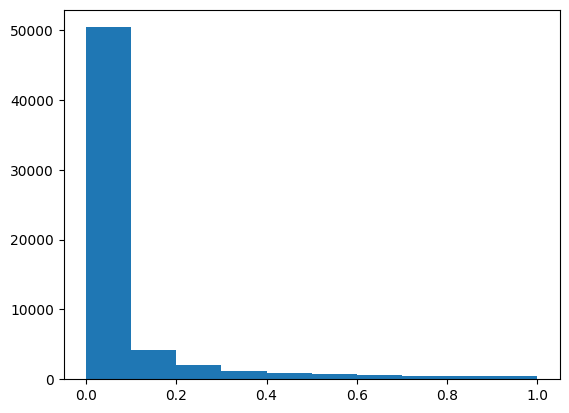

In [36]:
y_proba_bst=best_model_bst_gs.predict_proba(X_test_norm)[:, 1]
y_pred_bst=best_model_bst_gs.predict(X_test_norm)
plt.hist(y_proba_bst)

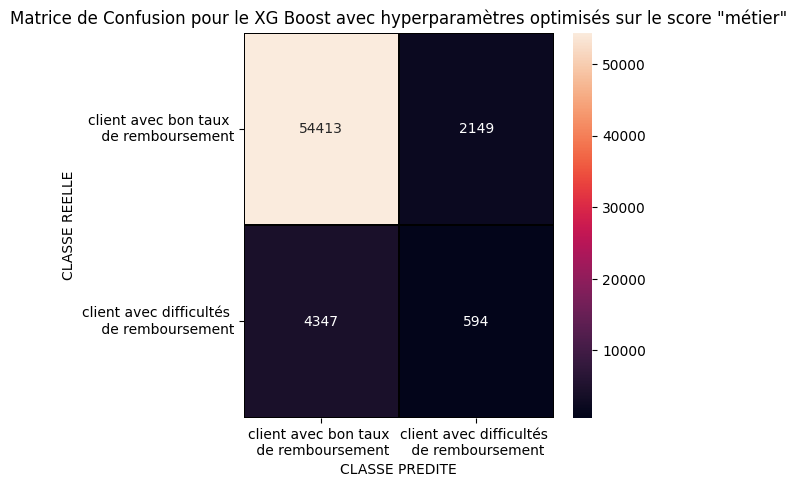

In [37]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_pred_bst)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XG Boost avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [38]:
# score du XG Boost avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_bst)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_bst)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_bst)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_bst)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_bst, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_bst)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_bst)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_bst)))

Accuracy Score : 0.8943791359771068
Precision Score : 0.2165512212905578
Recall Score : 0.12021857923497267
F1 Score : 0.15460697553357627
F beta Score (avec beta=3) : 0.12581547064305684
Aire sous la courbe ROC : 0.6865270704908064
Aire sous la courbe PR : 0.15554777761036465
Score de couts des erreurs de prédiction : 45619


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [39]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_bst_train = best_model_bst_gs.predict_proba(X_train_norm)[:, 1]
y_pred_bst_train = best_model_bst_gs.predict(X_train_norm)

Best Threshold : 0.15
Best Score : 29883


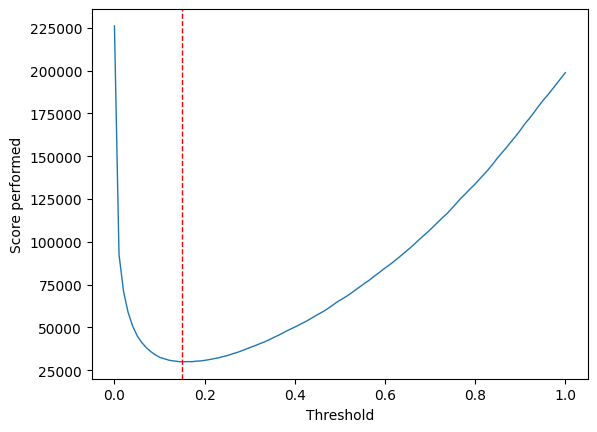

In [40]:
threshold_selection_cout(y_proba_bst_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [41]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_bst_opt_test = (best_model_bst_gs.predict_proba(X_test_norm)[:,1] >= 0.15).astype(int)
y_bst_opt_proba_test = best_model_bst_gs.predict_proba(X_test_norm)[:, 1]

In [42]:
# score du XG Boost avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_bst_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_bst_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_bst_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_bst_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_bst_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_bst_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_bst_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_bst_opt_test)))

Accuracy Score : 0.829845698583809
Precision Score : 0.17876250290765294
Recall Score : 0.3110706334750051
F1 Score : 0.22704778787207328
F beta Score (avec beta=3) : 0.28963385908379974
Aire sous la courbe ROC : 0.5931170854161206
Aire sous la courbe PR : 0.11095465866852539
Score de couts des erreurs de prédiction : 41101


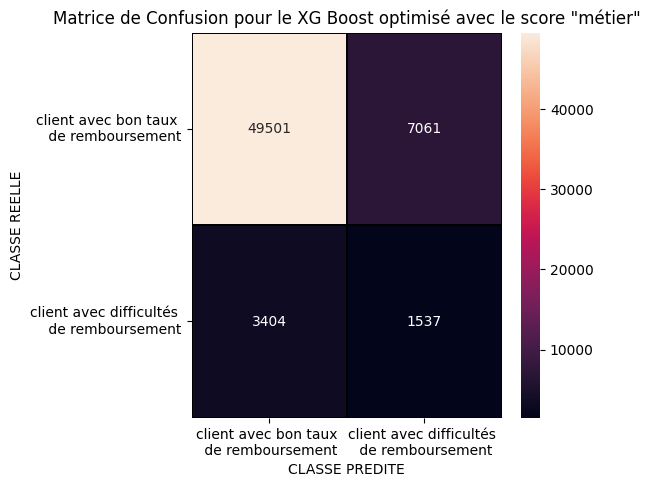

In [43]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_bst_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XG Boost optimisé avec le score "métier"')
plt.show()

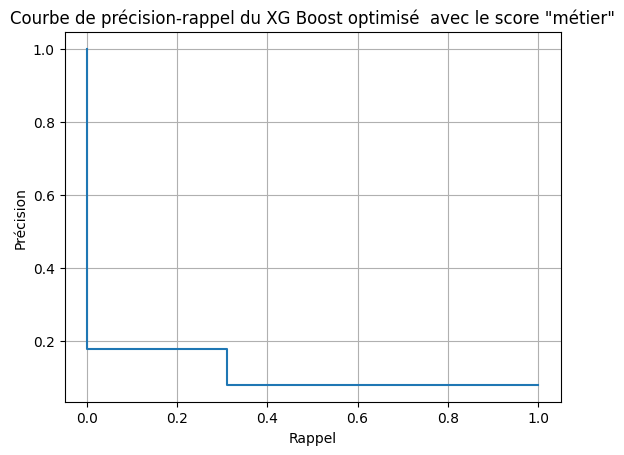

In [44]:
# Graphique précision-rappel
precision_bst, recall_bst, _ = precision_recall_curve(y_test, y_bst_opt_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_bst, recall=recall_bst)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du XG Boost optimisé  avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du XG Boost optimisé avec le score "métier"')

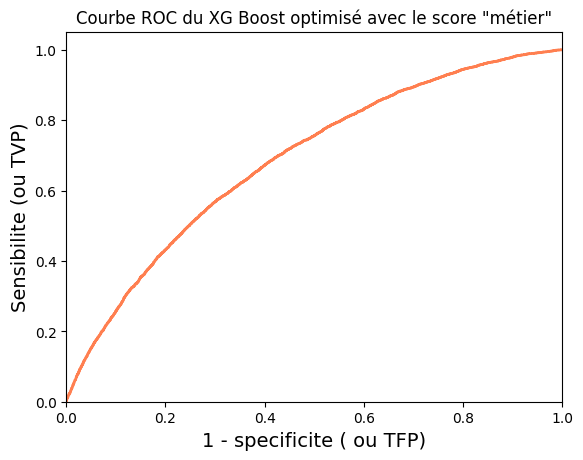

In [45]:
# Graphique courbe ROC
[fpr_bst, tpr_bst, thr_bst] = metrics.roc_curve(y_test, y_bst_opt_proba_test)
plt.plot(fpr_bst, tpr_bst, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du XG Boost optimisé avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

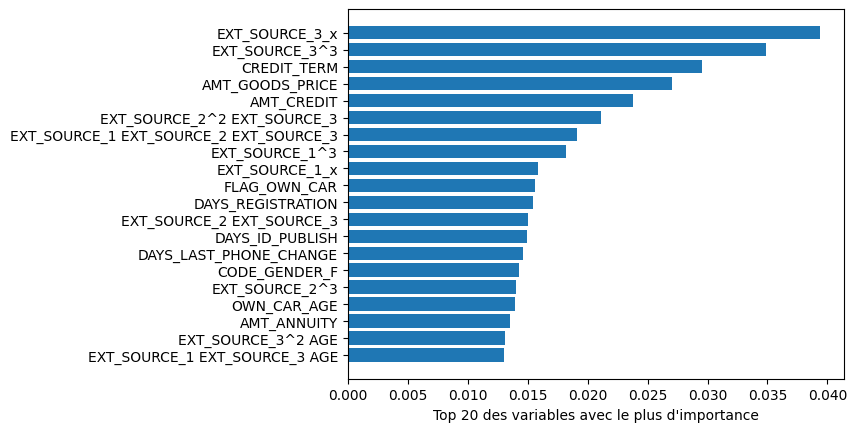

In [47]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_bst_gs, X_train_norm,y_train)

feature_names = X_train_norm.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Nous pouvons voir que les combinaisons créée avec les 3 données EXT_SOURCE, en particulier la 3, ont une importance beaucoup plus élevée que toutes les autres dans ce modèle optimisé de XGBoost. Les variables 'CREDIT_TERM", "AMT_GOODS_PRICE" et "AMT_CREDIT" ont également un certain poids dans ce modèle.


### Choix du modèle :

Puisque notre but est de minimiser notre score "métier", l'algorithme de régression logistique semble le mieux adapté avec un score "métier" de 34397.

<!-- Cependant, ses temps d'entrainement et de prédiction sont les plus importants.

Privilégions tout de même la performance et donc l'algorithme de forêt aléatoire dans ce premier temps, ce qui nous permettra également d'avoir une bonne explicabilité.

## Explication du modèle :

Observons maintenant comment les variables les plus importantes influencent les prédictions avec la fonction SHAP. -->